## Imports libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score

from scipy.integrate import cumtrapz

import os

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

## Utils Functions

In [51]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, input_sequence_length, target_feature):
        """
        Args:
            dataframe (pandas.DataFrame): Time series data, with each row representing a timestamp.
            input_sequence_length (int): Number of past time steps to use as input features for forecasting.
            target_feature (str): Name of the column containing the target feature to predict.
        """
        self.data = dataframe.values
        self.input_sequence_length = input_sequence_length
        self.target_feature_idx = dataframe.columns.get_loc(target_feature)

    def __len__(self):
        return len(self.data) - self.input_sequence_length

    def __getitem__(self, idx):
        input_sequence = self.data[idx:idx+self.input_sequence_length, :]
        target = self.data[idx+self.input_sequence_length, self.target_feature_idx]
        target = torch.tensor(target, dtype=torch.float)

        input_sequence = torch.FloatTensor(input_sequence)
        return input_sequence, target

In [52]:
def loader(data, target_col, seq_len, batch_size):
  """
    :param data: training dataframe
    :param target_col: target column name 
    :param seq_len: sequence length
    :param batch_size:  
    :return: DataLoader
  """
  dataset = TimeSeriesDataset(data, input_sequence_length=seq_len, target_feature=target_col)
  dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
  return dataset_loader

In [53]:
def normalize(dataframe, mean=None, std=None):
  """
  function to normalize a given dataframe
  :param dataframe: dataframe to be normalized
  :return: a normalized dataframe
  """
  if mean is None and std is None:
    # calculate mean and standard deviation
    mean = dataframe.mean()
    std = dataframe.std()

  # normalize the data
  dataframe = (dataframe - mean) /std

  return dataframe, mean, std

In [54]:
def denormalize(dataframe, mean, std):
    """
    Function to denormalize a given dataframe based on the mean and standard deviation
    :param dataframe: dataframe to be denormalized
    :param mean: mean value used for normalization
    :param std: standard deviation used for normalization
    :return: a denormalized dataframe
    """
    # denormalize the data
    dataframe = (dataframe * std) + mean
    
    return dataframe


In [55]:
def flatten(l):
  """
  function that flattens a torch list of list
  :param l: a torch list of lists
  :return: flattened list with numpy values
  """
  return [item.numpy() for sublist in l for item in sublist]

In [56]:
def run_model(mode, model, train_dataloader, val_dataloader=None, lr=0.0001, wd=0.0001, epochs=1, patience=3):
    """
    function that runs the model in either training or evaluating mode
    :param mode: either "train" or "eval"
    :param model: model to be trained/evaluated
    :param lr: learning rate
    :param epochs: number of epochs
    :param patience: number of epochs to wait before stopping if validation loss doesn't improve
    :return: y_true, y_pred
    """
    if mode == 'train':
        model.train()
        desc = 'Training'
    elif mode == 'eval':
        model.eval()
        desc = 'Evaluating'
    else:
        raise ValueError("Mode must be 'train' or 'eval'.")

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    losses = []
    y_pred_t = []
    y_pred_e = []

    best_val_loss = float('inf')
    epochs_since_improvement = 0
    val_loss=0

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        y_pred_t.clear()


        with torch.set_grad_enabled(mode == 'train'):
            for inputs, targets in train_dataloader:
                # Zero the gradients
                model.zero_grad()

                # Forward pass
                outputs = model(inputs)

                
                # get y_true,y_pred and time
                y_pred_t.append(outputs)

                # Compute the loss
                targets = targets.unsqueeze(1)
                loss = nn.MSELoss()(outputs, targets)
                total_loss += loss.item()
                num_batches += 1
                losses.append(loss.item())

                # Backward pass and optimization
                if mode == 'train':
                    loss.backward()
                    optimizer.step()

            # Compute validation loss
            if val_dataloader is not None:
                val_loss = 0.0
                model.eval()
                y_pred_e.clear()

                with torch.no_grad():
                    for inputs, targets in val_dataloader:
                        outputs = model(inputs)
                        y_pred_e.append(outputs)
                        targets = targets.unsqueeze(1)
                        loss = nn.MSELoss()(outputs, targets)
                        val_loss += loss.item()
                val_loss /= len(val_dataloader)

                # Check for improvement in validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_since_improvement = 0
                else:
                    epochs_since_improvement += 1

                if epochs_since_improvement >= patience:
                    print(f'Early stopping: no improvement in validation loss for {patience} epochs.')
                    break

                model.train()

        avg_loss = total_loss / num_batches

        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs} - {desc} Loss: {avg_loss: } - Val Loss: {val_loss: }')

    return y_pred_t, y_pred_e


In [57]:
def flatten_d(l):
  """
  function that flattens a torch list of list
  :param l: a torch list of lists
  :return: flattened list with numpy values
  """
  return [item.detach().numpy() for sublist in l for item in sublist]

In [58]:
def get_loaders(dataframe, seq_len, batch_size, target_col, test_size):
  """
  function that takes a dataset in dataframe form and returns dataloaders
    :param dataframe: dataframe of the dataset
    :param seq_len: sequence length
    :param batch_size: 
    :param target_col: name of the target column 
    :param test_size: ratio of the testing data 
    :return: train_loader, test_loader, val_loader
  """
  
  test_size = 1-test_size
  idx = int(len(dataframe) * test_size)
  # split dataset
  train, test_t = dataframe[:idx], dataframe[idx:]
  idx = int(len(test_t)/2)
  eval,test = test_t[:idx],test_t[idx:]

  # normalize the datasets
  train, x_mean, x_std = normalize(train)
  test,_,_ = normalize(test, x_mean, x_std)
  eval,_,_ = normalize(eval, x_mean,x_std)

  
  # get train and val loaders
  train_loader= loader(train, target_col, seq_len=seq_len, batch_size=batch_size)
  test_loader = loader(test,target_col, seq_len=seq_len, batch_size=1)
  val_loader = loader(eval,target_col, seq_len=seq_len, batch_size=1)

  return train_loader, test_loader, val_loader,x_mean, x_std, train,test,eval



In [59]:
def plot_actual_pred(y_true, y_pred, title):
  # get MSE score
  mse = mean_squared_error(y_true,y_pred)

  #get R2 score
  r2= r2_score(y_true, y_pred)

  # plot graph
  plt.figure(figsize=(10,10))
  plt.scatter(y_true, y_pred, c='crimson')
  plt.title(f"{title}\n MSE={mse} R2={r2}")

  p1 = max(max(y_true), max(y_pred))
  p2 = min(min(y_true), min(y_pred))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()

In [60]:
def plot_cycle_actual_pred(y_true, y_pred, cycle_id, start_time,title):

  fig, axs = plt.subplots(nrows=len(set(start_time)), figsize=(15, 15))


  for i, time in enumerate(set(start_time)):
      x_vals = [cycle_id[j] for j in range(len(cycle_id)) if start_time[j] == time]
      y_true_vals = [y_true[j] for j in range(len(y_true)) if start_time[j] == time]
      y_pred_vals = [y_pred[j] for j in range(len(y_pred)) if start_time[j] == time]
      
      axs[i].plot(x_vals, y_true_vals, label="True")
      axs[i].plot(x_vals, y_pred_vals, label="Predicted")
      axs[i].set_xlabel("Cycle ID")
      axs[i].set_ylabel("Value")
      axs[i].set_title(f"Start Time = {time}")
      axs[i].legend()

  #plt.tight_layout()
  plt.axis("auto")
  plt.tight_layout(pad=1)
  plt.title(title)
  plt.show()

In [61]:
def train_eval_model(model,df,epochs,title,seq_len,test_size, batch_size,lr=0.0001, wd=0.0001):
  
  train_loader,test_loader,eval_loader,mean,std ,train,test,eval = get_loaders(df, seq_len=seq_len, batch_size=batch_size, test_size=test_size,target_col=title)
  print(f"Starting training {title}")
  y_pred_train, y_pred_eval = run_model("train",model, train_loader, eval_loader,lr=lr, wd=wd,epochs=epochs)
  y_pred_eval = flatten(y_pred_eval)
  y_pred_train = flatten_d(y_pred_train)

  print("Plots for last training epoch")
    # get MSE score
  mse = mean_squared_error(train[title][seq_len:],y_pred_train)

  #get R2 score
  r2= r2_score(train[title][seq_len:], y_pred_train)

  # denormalize for plotting
  y_true = denormalize(np.asarray(train[title][seq_len:]), mean[title], std[title])
  y_pred = denormalize(np.asarray(y_pred_train), mean[title], std[title])
  cycle = denormalize(np.asarray(train["Cycle ID"][seq_len:]), mean["Cycle ID"], std["Cycle ID"])
  start_times = denormalize(np.asarray(train["start_time"][seq_len:]), mean["start_time"], std["start_time"])
  start_times = start_times.astype('int')


  # plot predicted values and actual values against cycle number
  plot_cycle_actual_pred(y_true, y_pred,cycle, start_times,f"{title} R2={r2} MSE={mse}")

  print(seq_len)
  print("Plots for last evaluation")
    # get MSE score
  print(len(eval[title][seq_len:]))
  print(len(y_pred_eval))
  mse = mean_squared_error(eval[title][seq_len:],y_pred_eval)

  #get R2 score
  r2= r2_score(eval[title][seq_len:], y_pred_eval)

  # denormalize for plotting
  y_true = denormalize(np.asarray(eval[title][seq_len:]), mean[title], std[title])
  y_pred = denormalize(np.asarray(y_pred_eval), mean[title], std[title])
  cycle = denormalize(np.asarray(eval["Cycle ID"][seq_len:]), mean["Cycle ID"], std["Cycle ID"])
  start_times = denormalize(np.asarray(eval["start_time"][seq_len:]), mean["start_time"], std["start_time"])
  start_times = start_times.astype('int')


  # plot predicted values and actual values against cycle number
  plot_cycle_actual_pred(y_true, y_pred,cycle, start_times,f"{title} R2={r2} MSE={mse}")

  print(f"Starting evaluating {title}")
  # evaluate the model

  y_pred_test, _= run_model("eval", model, test_loader)
  
  # get MSE score
  mse = mean_squared_error(test[title][seq_len:],flatten(y_pred_test))

  #get R2 score
  r2= r2_score(test[title][seq_len:], flatten(y_pred_test))

  # denormalize for plotting
  y_true = denormalize(np.asarray(test[title][seq_len:]), mean[title], std[title])
  y_pred = denormalize(np.asarray(flatten(y_pred_test)), mean[title], std[title])
  cycle = denormalize(np.asarray(test["Cycle ID"][seq_len:]), mean["Cycle ID"], std["Cycle ID"])
  start_times = denormalize(np.asarray(test["start_time"]), mean["start_time"], std["start_time"])
  start_times = start_times.astype('int')

  print(f"R2={r2} MSE={mse}")



  #plot predicted values and actual values against cycle number
  plot_cycle_actual_pred(y_true, y_pred,cycle, start_times,f"{title} R2={r2} MSE={mse}")

## Data Preparing

In [14]:
df = pd.read_csv("/content/drive/MyDrive/files/gt5_concatenated_full_features.csv")

In [15]:
df.drop("Cycle ID", axis=1, inplace=True)

In [16]:
df.rename(columns={"Unnamed: 0" : "Cycle ID"}, inplace=True)

In [17]:
df.head()

Cycle ID      time   current   voltage     power  pressure_anode_inlet  \
0         0    22.761  4.429146  0.828462  3.663077            109.901303   
1         1  1202.761  4.429146  0.839231  3.700000            109.823476   
2         2  2382.761  4.431238  0.838462  3.701538            109.823476   
3         3  3562.761  4.429892  0.838462  3.699231            109.839041   
4         4  4742.761  4.429892  0.830000  3.695385            109.753432   

   pressure_anode_outlet  pressure_cathode_inlet  pressure_cathode_outlet  \
0             110.296142              109.768997               108.986869   
1             110.125047              105.434040               104.702258   
2             110.078384              105.566345               104.834692   
3             110.039499              105.558563               104.780160   
4             110.062830              105.628607               104.974915   

   temp_anode_endplate  ...  temp_anode_outlet  temp_cathode_dewpoint_water  \
0            83.057949  ...          39.306658                    64.432531   
1            83.142231  ...          43.875925                    64.657081   
2            83.120389  ...          44.188886                    64.707359   
3            83.017021  ...          45.997551                    64.646116   
4            83.083964  ...          45.388960                    64.694729   

   temp_cathode_inlet  temp_cathode_outlet  total_anode_stack_flow  \
0           69.673591            55.817679                    0.07   
1           69.743695            60.898030                    0.07   
2           69.822516            60.226884                    0.07   
3           69.715006            60.008850                    0.07   
4           68.766315            59.172009                    0.07   

   total_cathode_stack_flow  cycle_len       energy  hydrogen  start_time  
0                     0.291     1160.0  8417.381065   778.490          50  
1                     0.291     1180.0  8463.960005   785.277          50  
2                     0.291     1180.0  8457.310000   785.273          50  
3                     0.291     1180.0  8449.390000   785.291          50  
4                     0.291     1180.0  8434.310000   785.291          50  

[5 rows x 22 columns]

In [18]:
df["e/h"] = df["energy"]/df["hydrogen"]
df["p/h"] = df["power"]/df["hydrogen"]

In [19]:
df.head()

Cycle ID      time   current   voltage     power  pressure_anode_inlet  \
0         0    22.761  4.429146  0.828462  3.663077            109.901303   
1         1  1202.761  4.429146  0.839231  3.700000            109.823476   
2         2  2382.761  4.431238  0.838462  3.701538            109.823476   
3         3  3562.761  4.429892  0.838462  3.699231            109.839041   
4         4  4742.761  4.429892  0.830000  3.695385            109.753432   

   pressure_anode_outlet  pressure_cathode_inlet  pressure_cathode_outlet  \
0             110.296142              109.768997               108.986869   
1             110.125047              105.434040               104.702258   
2             110.078384              105.566345               104.834692   
3             110.039499              105.558563               104.780160   
4             110.062830              105.628607               104.974915   

   temp_anode_endplate  ...  temp_cathode_inlet  temp_cathode_outlet  \
0            83.057949  ...           69.673591            55.817679   
1            83.142231  ...           69.743695            60.898030   
2            83.120389  ...           69.822516            60.226884   
3            83.017021  ...           69.715006            60.008850   
4            83.083964  ...           68.766315            59.172009   

   total_anode_stack_flow  total_cathode_stack_flow  cycle_len       energy  \
0                    0.07                     0.291     1160.0  8417.381065   
1                    0.07                     0.291     1180.0  8463.960005   
2                    0.07                     0.291     1180.0  8457.310000   
3                    0.07                     0.291     1180.0  8449.390000   
4                    0.07                     0.291     1180.0  8434.310000   

   hydrogen  start_time        e/h       p/h  
0   778.490          50  10.812446  0.004705  
1   785.277          50  10.778311  0.004712  
2   785.273          50  10.769898  0.004714  
3   785.291          50  10.759566  0.004711  
4   785.291          50  10.740362  0.004706  

[5 rows x 24 columns]



## Models

In [20]:
# @title MR-ESN
class CNNMultiReservoirESN(nn.Module):
    def __init__(self, input_size, hidden_size,reservoir_sizes, output_size, spectral_radius=0.95,kernel_size=3):
        super(CNNMultiReservoirESN, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.reservoir_sizes = reservoir_sizes
        self.spectral_radus = spectral_radius
        self.hidden_size = hidden_size

        # 1D Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size)

        # Max pooling layer
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        
        # Create the input-to-reservoir weight matrix
        self.W_in = nn.Linear(hidden_size, sum(reservoir_sizes), bias=False)
        
        # Create the reservoir-to-reservoir weight matrices for each reservoir
        self.W_res = nn.ModuleList()
        for res_size in reservoir_sizes:
            W = nn.Linear(res_size, res_size, bias=False)
            W.weight.data *= spectral_radius / torch.max(torch.abs(torch.linalg.eig(torch.randn(res_size, res_size))[0]))
            self.W_res.append(W)
        
        # Create the reservoir-to-output weight matrix
        self.W_out = nn.Linear(sum(reservoir_sizes), output_size, bias=False)
        
    def forward(self, x):

        # Pass input through the Conv1D layer and apply max pooling
        x = x.permute(0, 2, 1)  # Swap the time dimension with the feature dimension for the Conv1D layer
        x = self.conv1d(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)  # Swap back the dimensions after pooling

        # Create the initial reservoir state
        h = torch.zeros(1, sum(self.reservoir_sizes))
        
        # Iterate over the input sequence
        for i in range(x.size(1)):
            u = x[:, i, :]
            
            # Compute the reservoir states for each reservoir
            reservoir_states = []
            start_idx = 0
            for W_res in self.W_res:
                end_idx = start_idx + W_res.weight.size(0)
                res_in = self.W_in(u)[:, start_idx:end_idx]
                res_res = torch.mm(h[:, start_idx:end_idx], W_res.weight)
                h_res = torch.tanh(res_in + res_res)
                reservoir_states.append(h_res)
                start_idx = end_idx
            h = torch.cat(reservoir_states, dim=1)
        
        # Compute the output
        y = self.W_out(h)
        
        return y

## Training and Inference CNNMultiReservoirESN

for power, voltage and energy, 33% of the original data has been used for evaluation

In [21]:
num_features = df.shape[1] 
hidden_size = 32
num_layers = 1
learning_rate = 0.001
output_size = 1 

Starting training power
Epoch 1/120 - Training Loss:  0.4042961990003121 - Val Loss:  0.15844919243276567
Early stopping: no improvement in validation loss for 3 epochs.
Plots for last training epoch


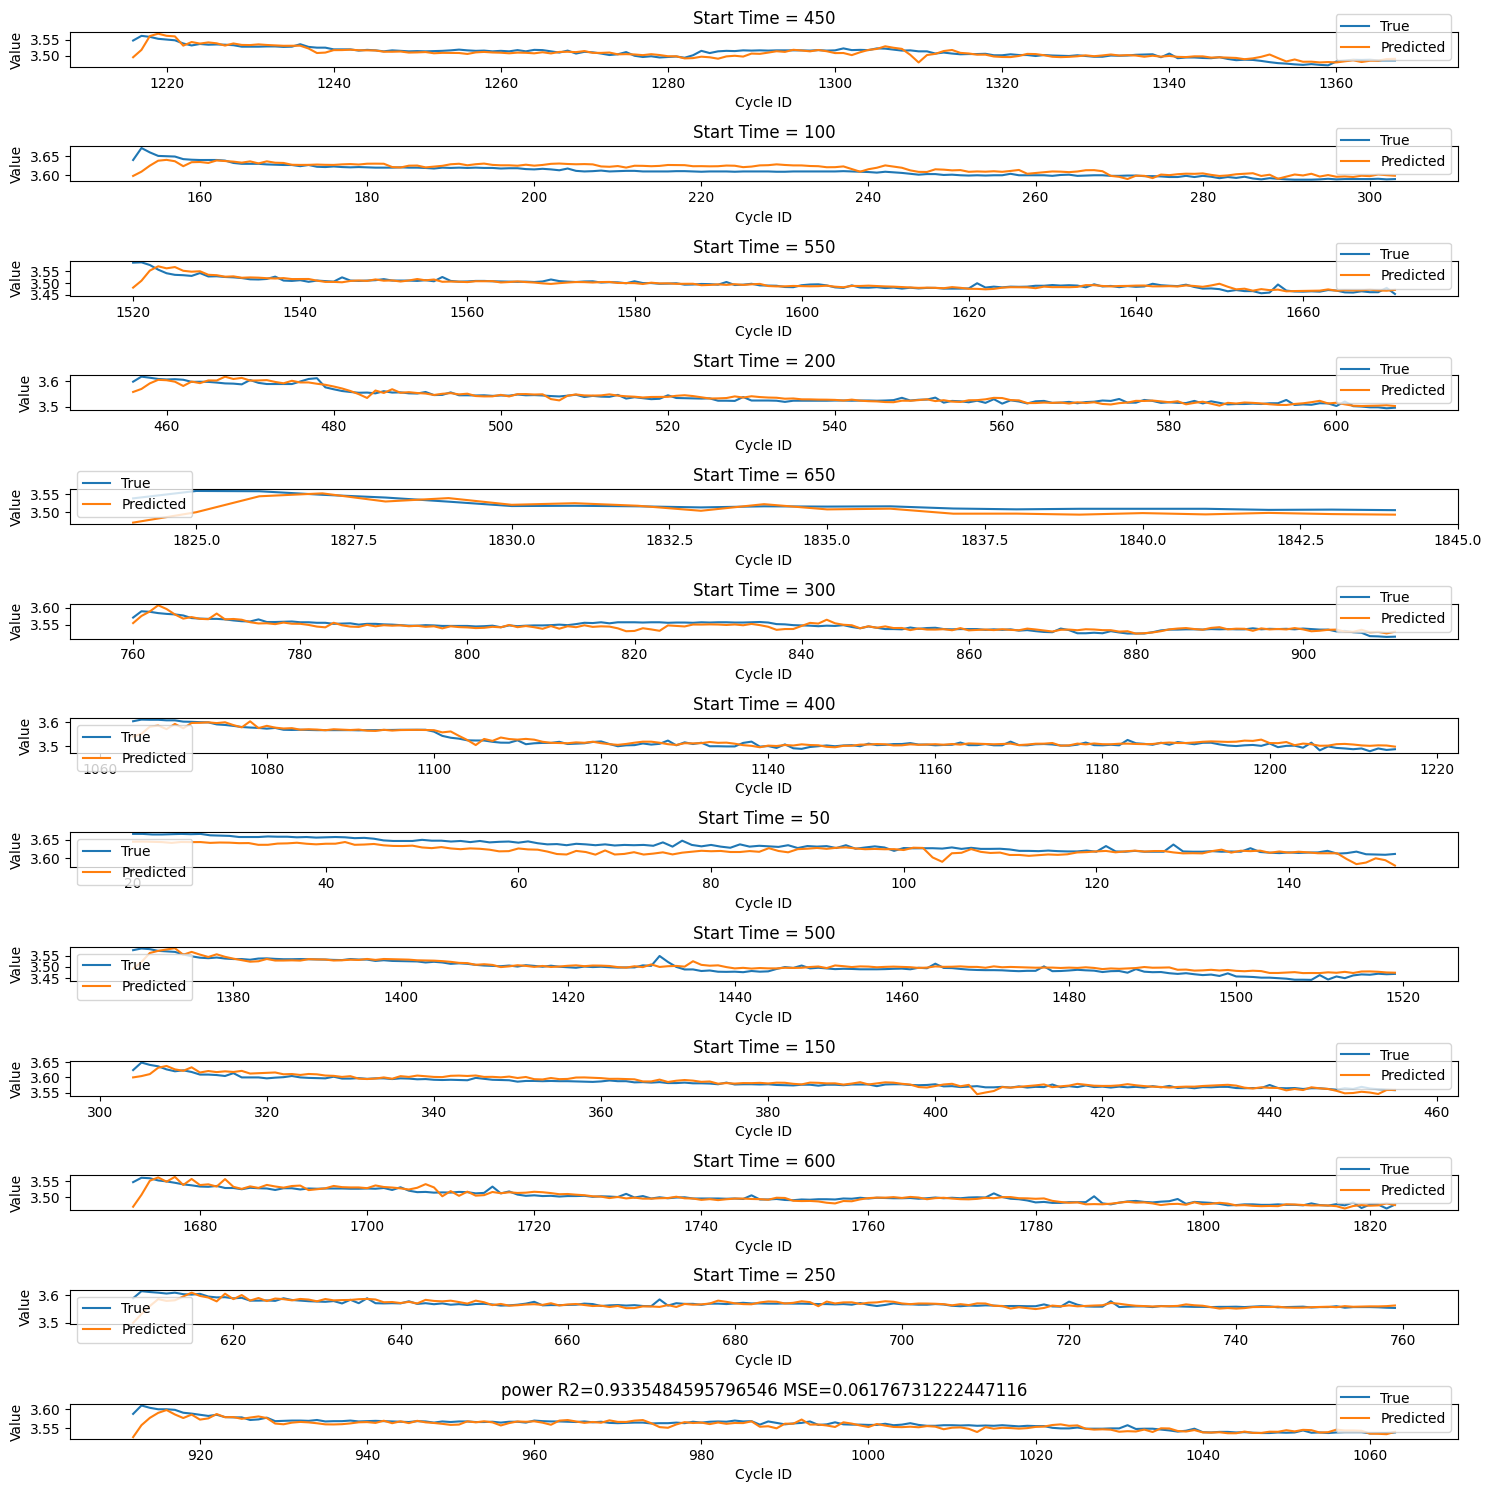

20
Plots for last evaluation
595
595


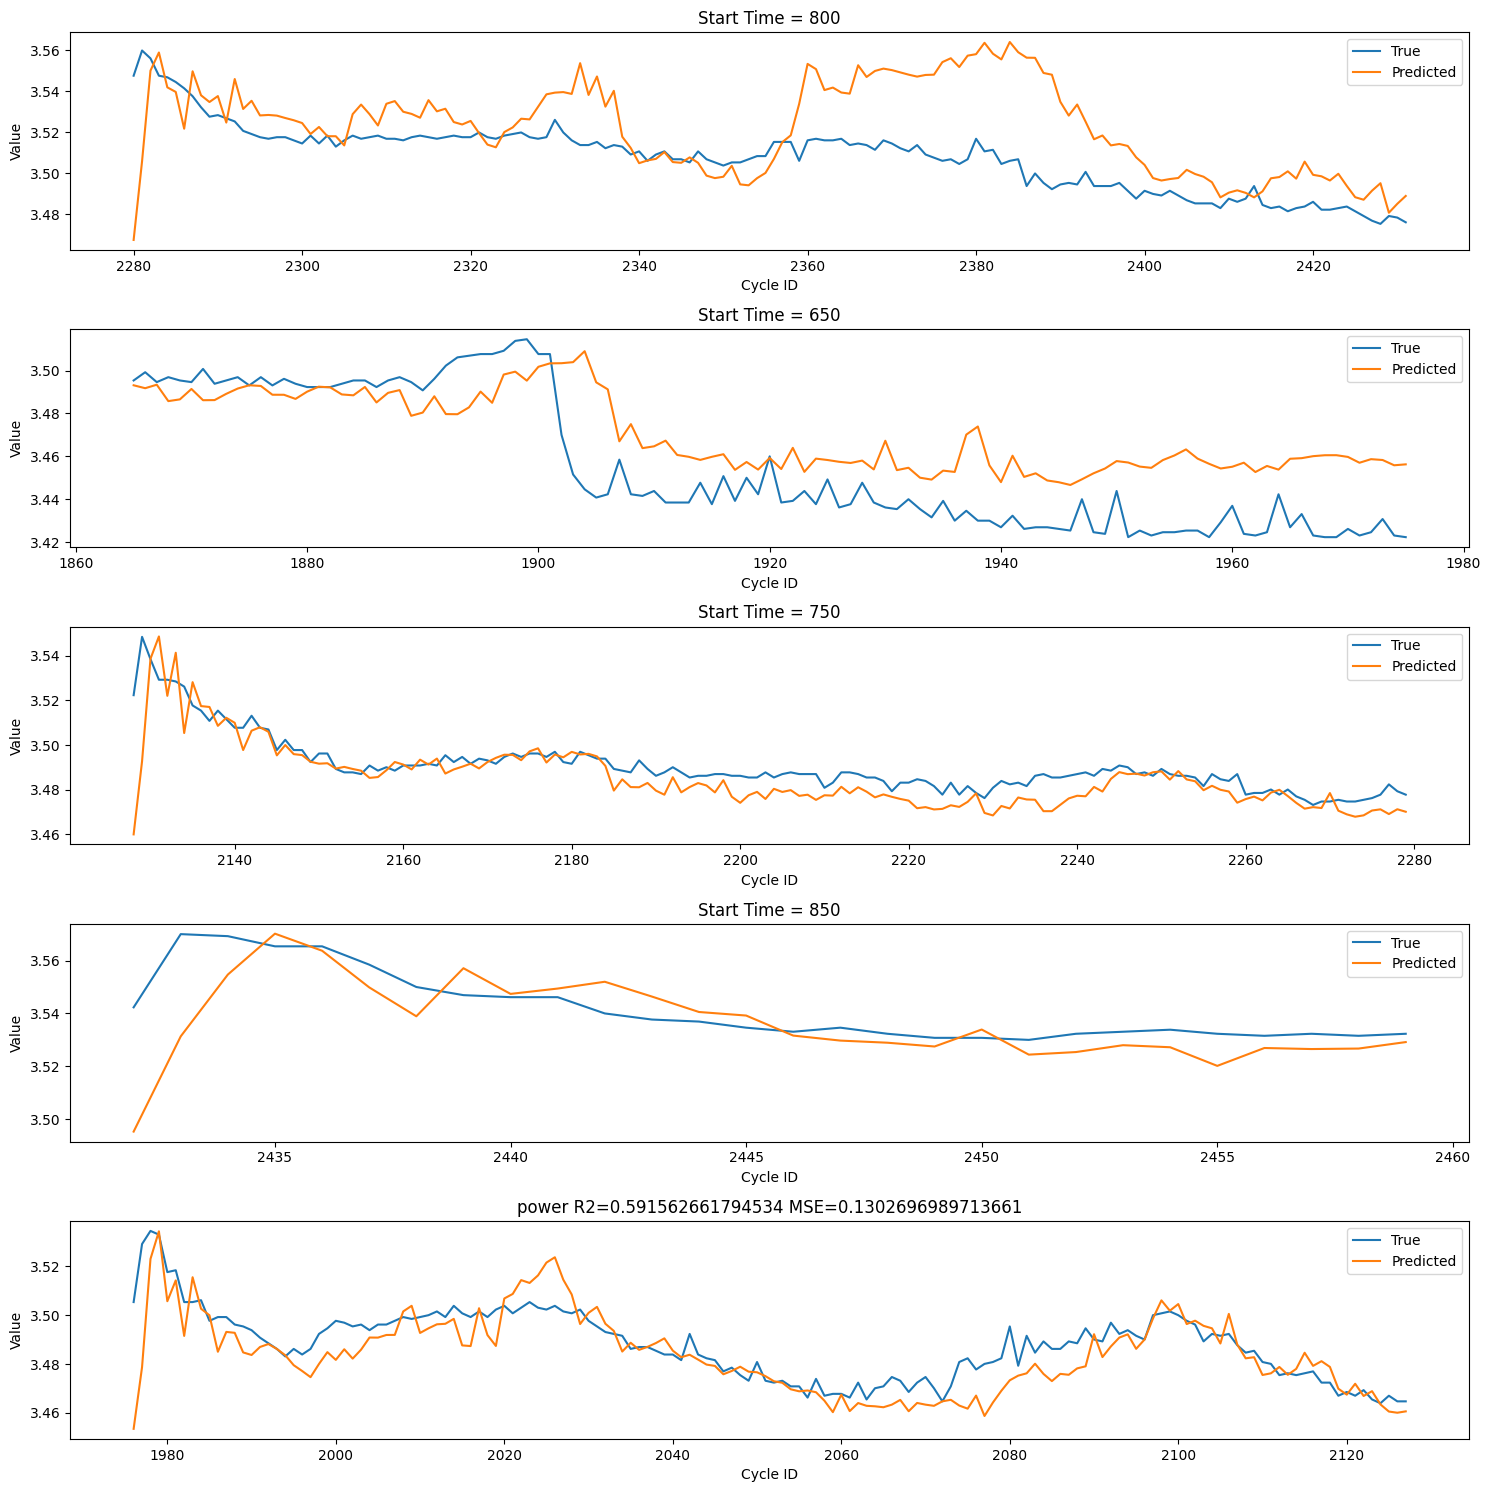

Starting evaluating power
Epoch 1/1 - Evaluating Loss:  0.057909525485388566 - Val Loss:  0
R2=0.5318065402738871 MSE=0.05790952557915283


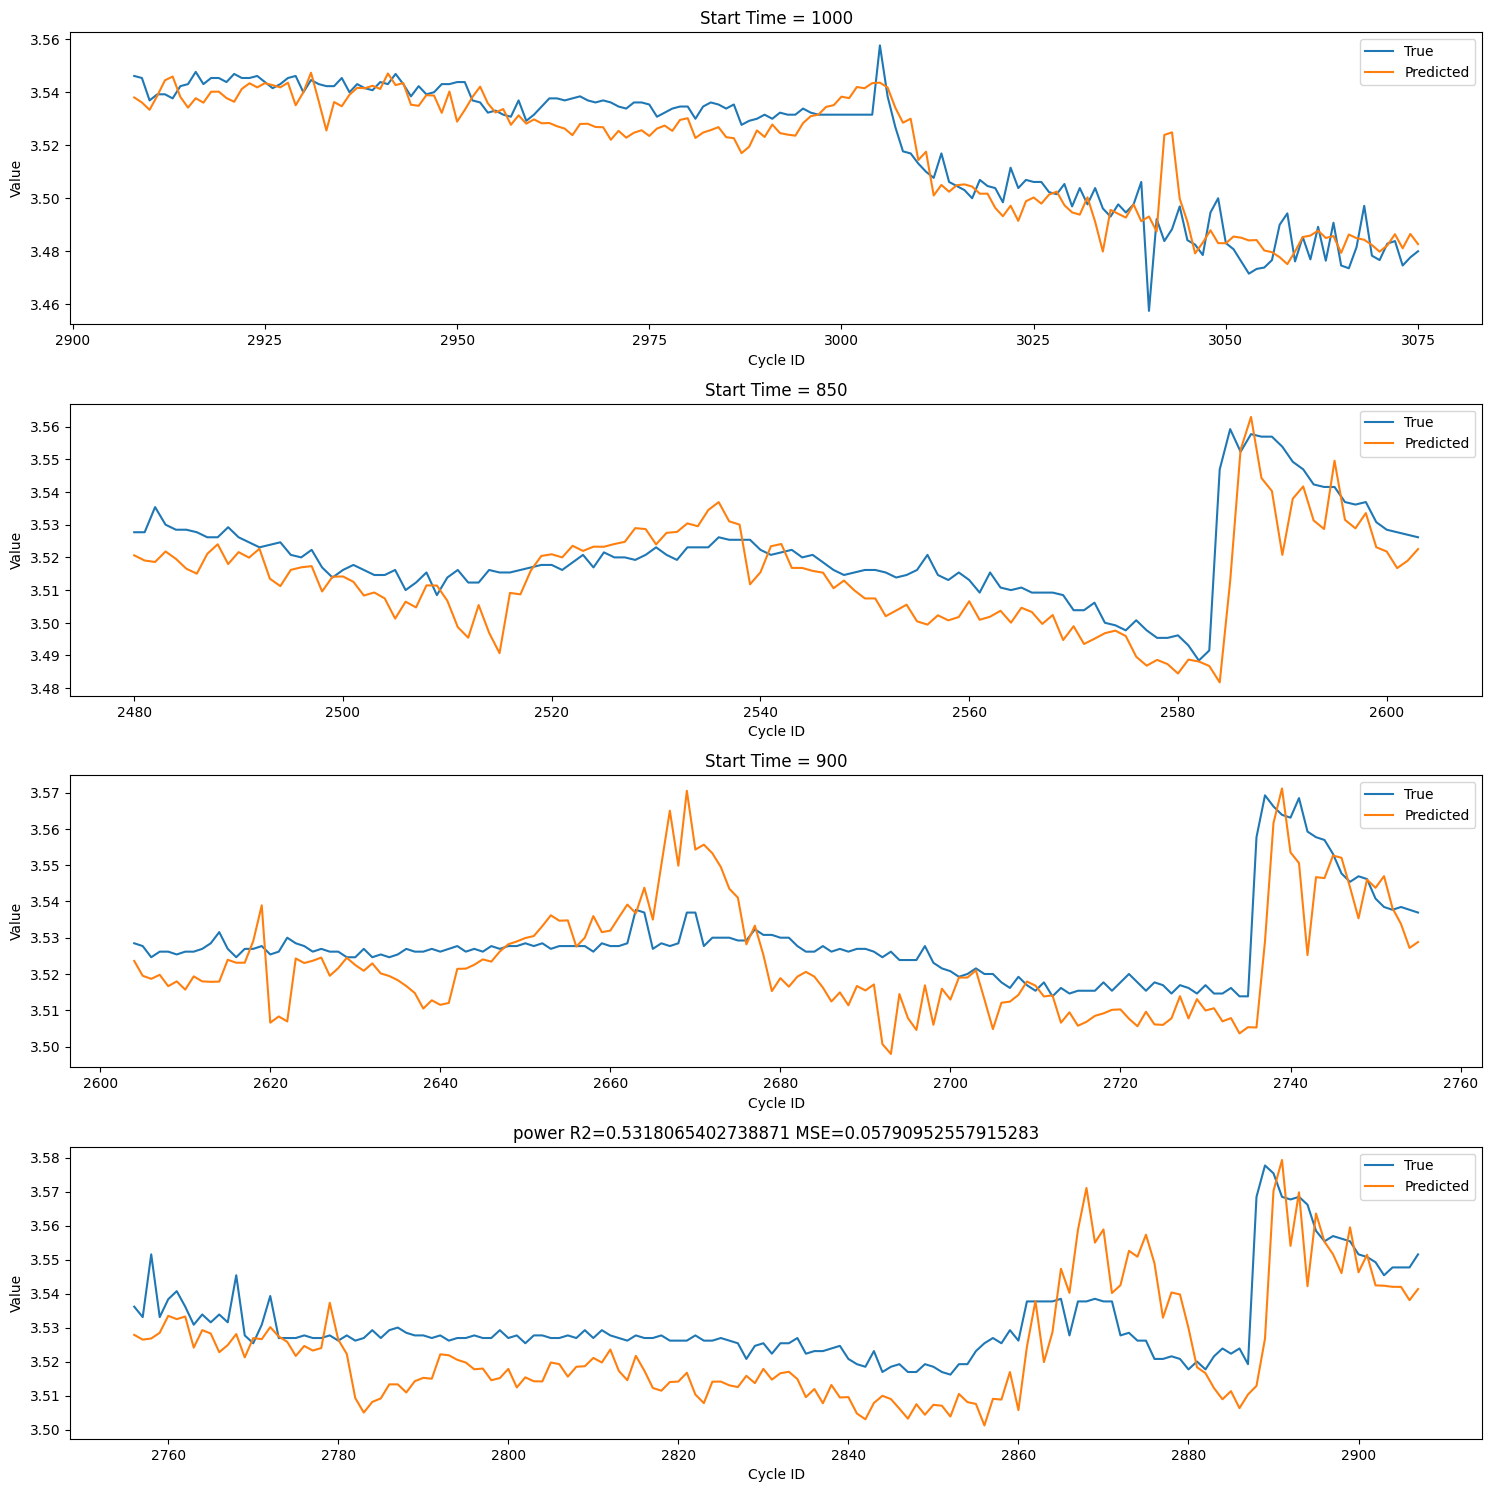

In [75]:
#@title Power


# instantiate the model
model = CNNMultiReservoirESN(num_features, 16,[500], output_size, 0.95)
# train and evaluate the model
train_eval_model(model, df, seq_len=20, batch_size=32,test_size=0.4,lr=0.0001, wd=0.0001, epochs=120, title="power")

Starting training energy
Epoch 1/80 - Training Loss:  0.7810834909243316 - Val Loss:  0.6609660357907047
Epoch 11/80 - Training Loss:  0.1002300934432524 - Val Loss:  0.06918320570771422
Early stopping: no improvement in validation loss for 3 epochs.
Plots for last training epoch


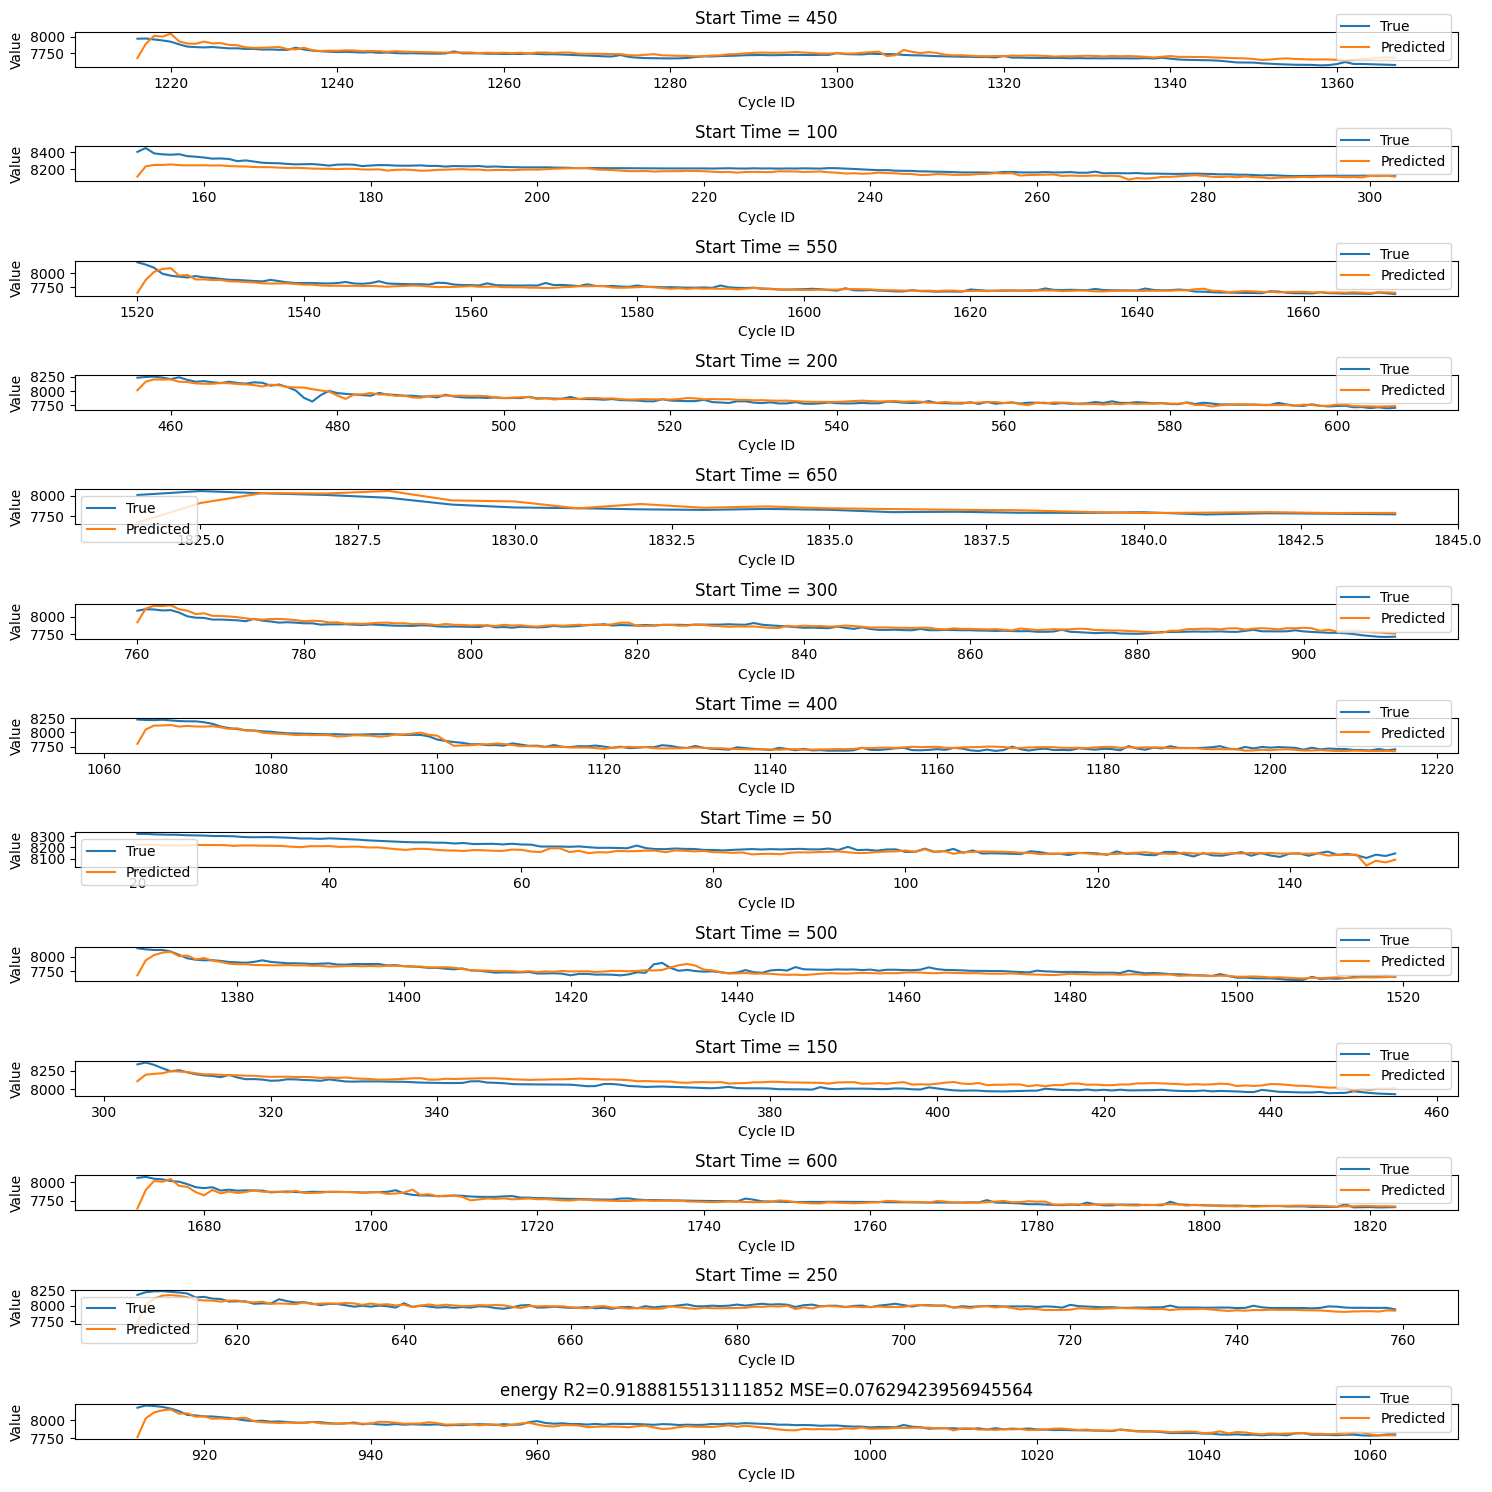

20
Plots for last evaluation
595
596


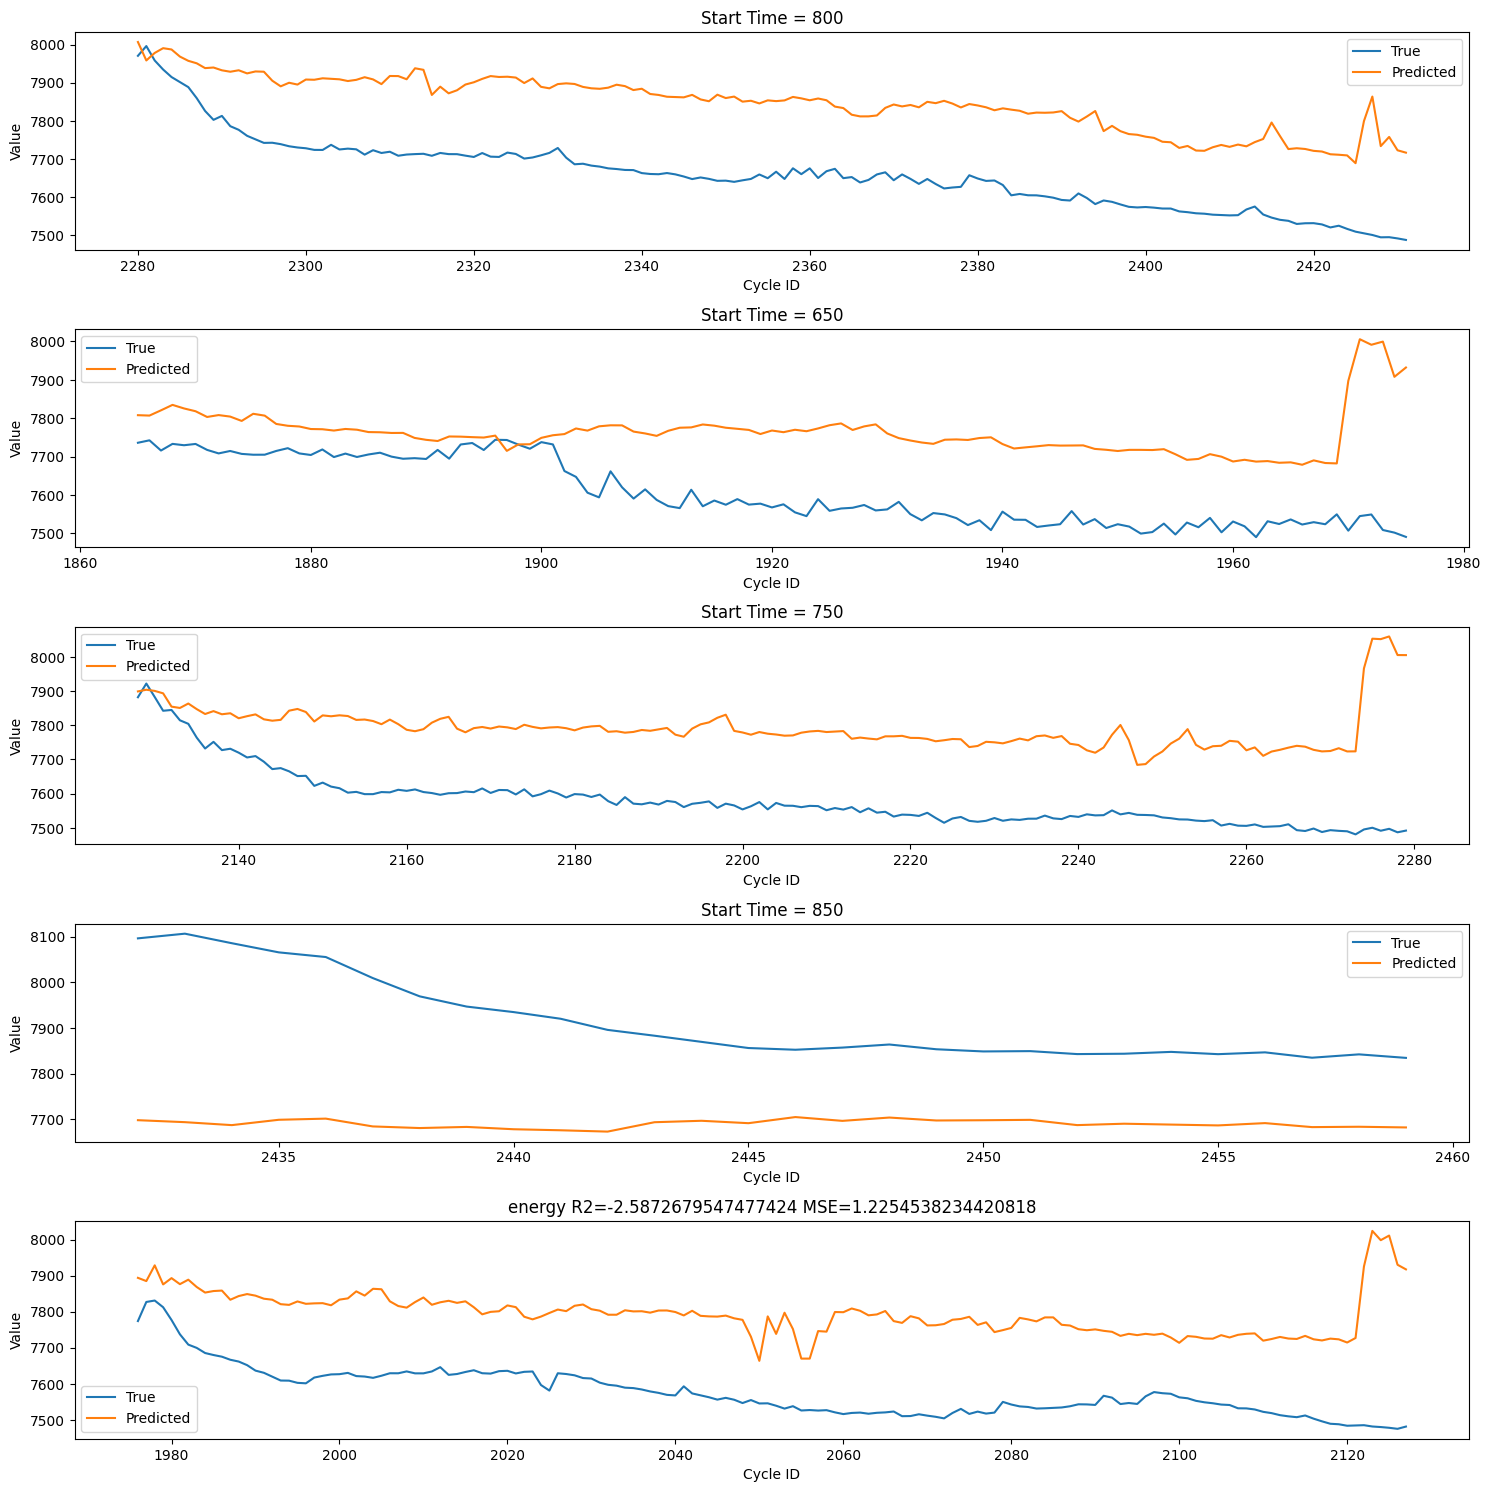

Starting evaluating energy
Epoch 1/1 - Evaluating Loss:  0.0643207252203775 - Val Loss:  0
R2=0.7573058214277234 MSE=0.06432072495399092


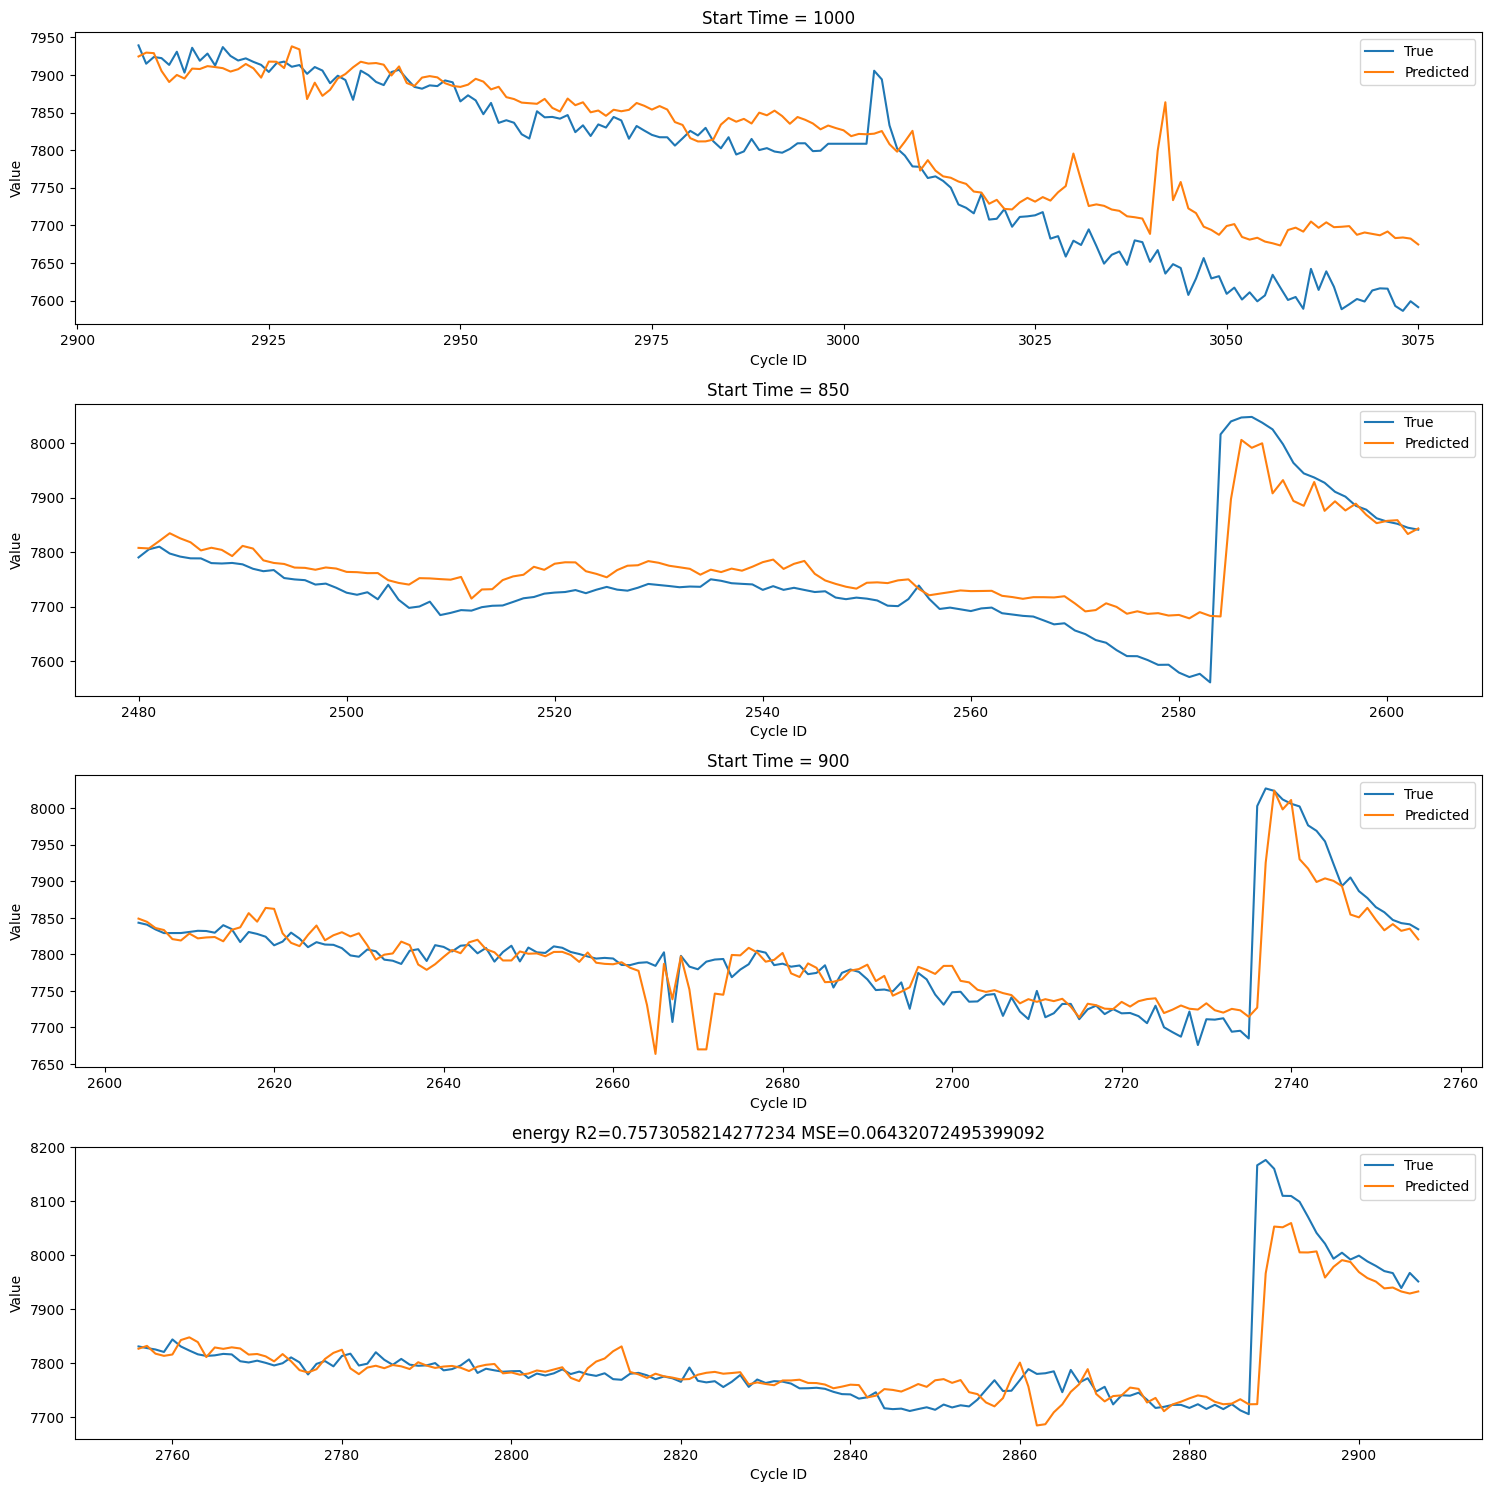

In [25]:
#@title Energy
# get data
# train_loader, test_loader,eval_loader,  x_mean, x_std = get_loaders(df,seq_len=20, batch_size=32, target_col="energy", test_size=0.4)
# y_mean = x_mean["energy"]
# y_std = x_std["energy"]

# instantiate the model
model = CNNMultiReservoirESN(num_features, 16,[32], output_size, 0.95)

# train and evaluate the model
train_eval_model(model, df, seq_len=20, batch_size=32, test_size=0.4,epochs=80, title="energy")

Starting training voltage
Epoch 1/200 - Training Loss:  0.8832828709052811 - Val Loss:  1.1925837308887242
Epoch 11/200 - Training Loss:  0.08731941852702535 - Val Loss:  0.15371402203564768
Epoch 21/200 - Training Loss:  0.06931935737696315 - Val Loss:  0.1373966117602584
Epoch 31/200 - Training Loss:  0.057259274314454725 - Val Loss:  0.1178830212981772
Epoch 41/200 - Training Loss:  0.049383284422721524 - Val Loss:  0.10707675727468954
Epoch 51/200 - Training Loss:  0.04447153144002218 - Val Loss:  0.1003316064767885
Epoch 61/200 - Training Loss:  0.04126767012900833 - Val Loss:  0.0934182051603878
Epoch 71/200 - Training Loss:  0.03912633553885951 - Val Loss:  0.08744012250563613
Epoch 81/200 - Training Loss:  0.03765033928131492 - Val Loss:  0.08341988748361043
Epoch 91/200 - Training Loss:  0.036534515281753804 - Val Loss:  0.08059434799896985
Epoch 101/200 - Training Loss:  0.035608414412026515 - Val Loss:  0.07837347693090403
Epoch 111/200 - Training Loss:  0.03479855930320276 

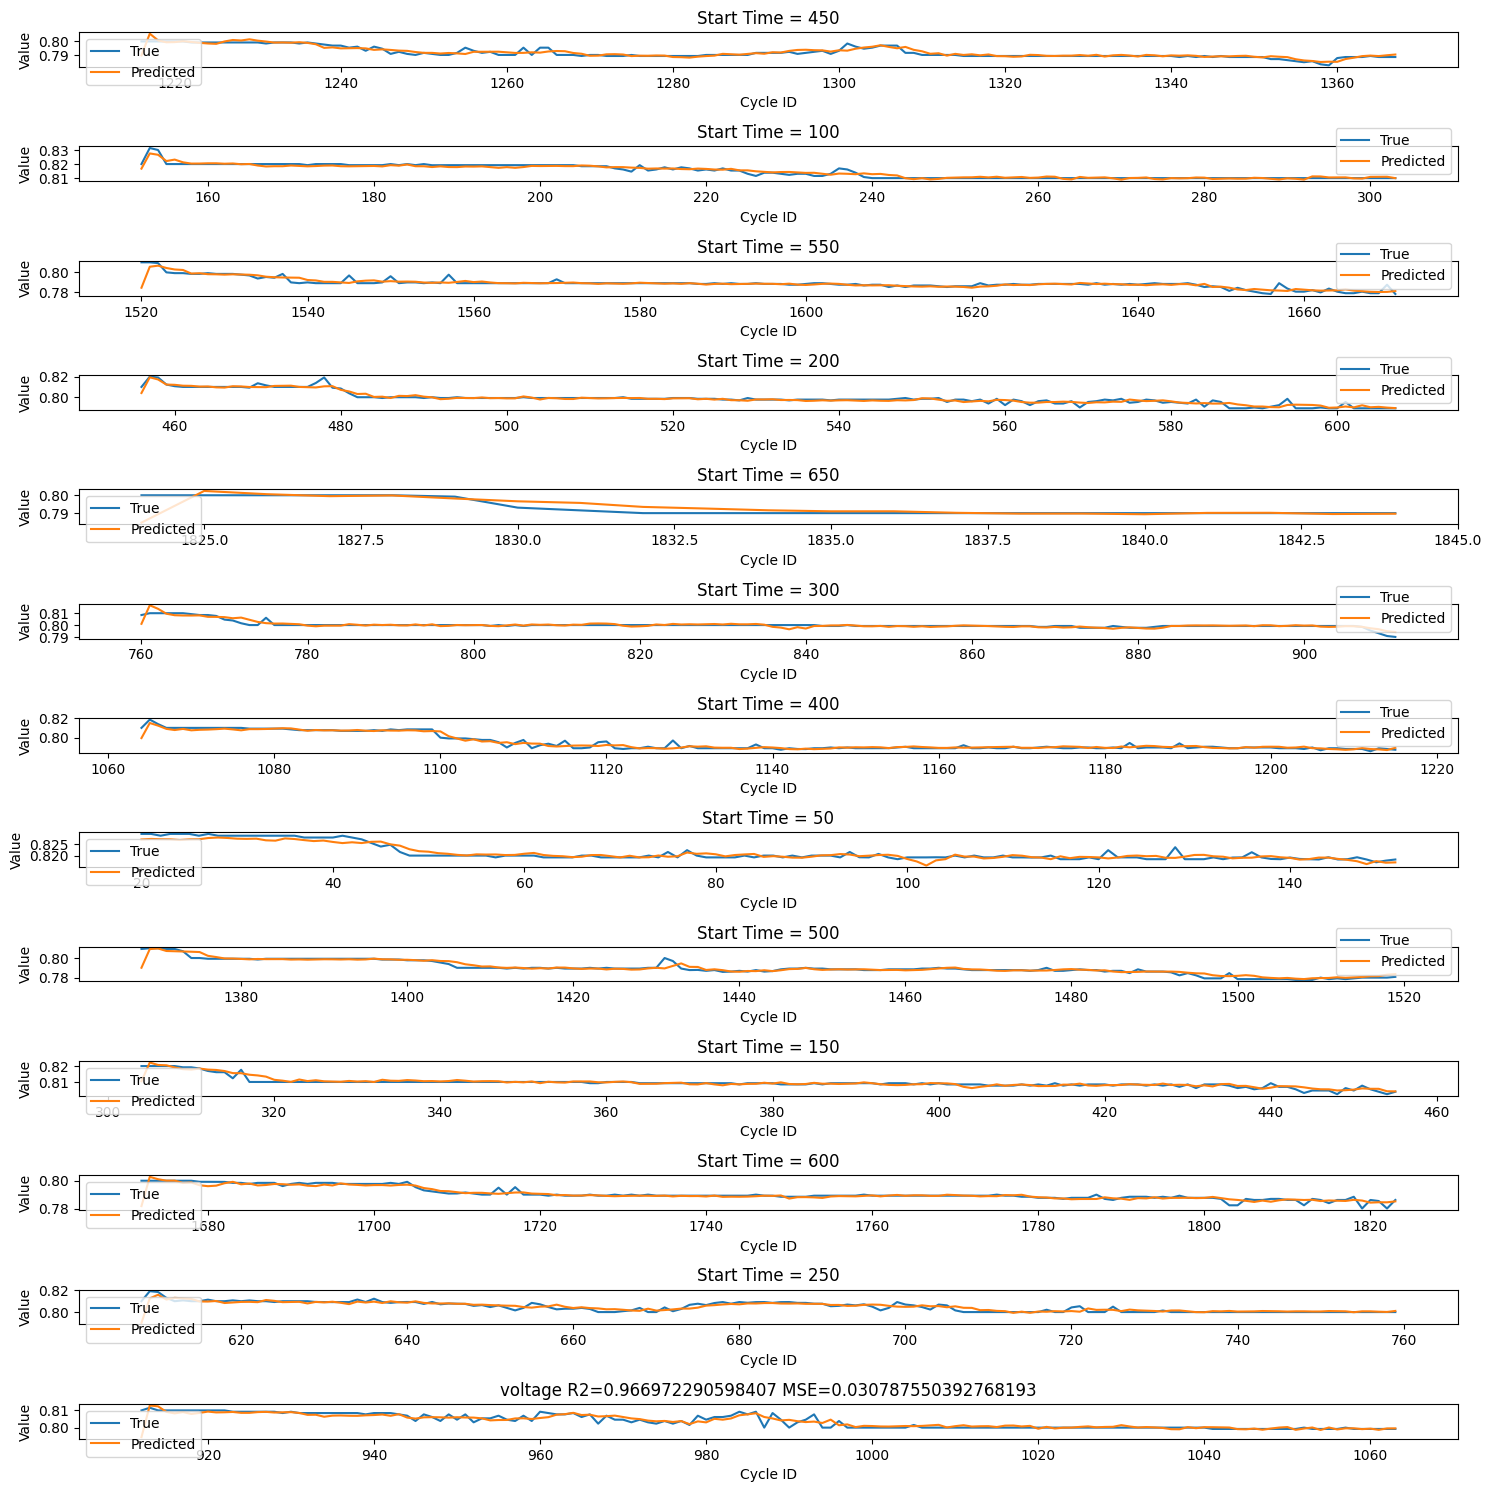

20
Plots for last evaluation
595
595


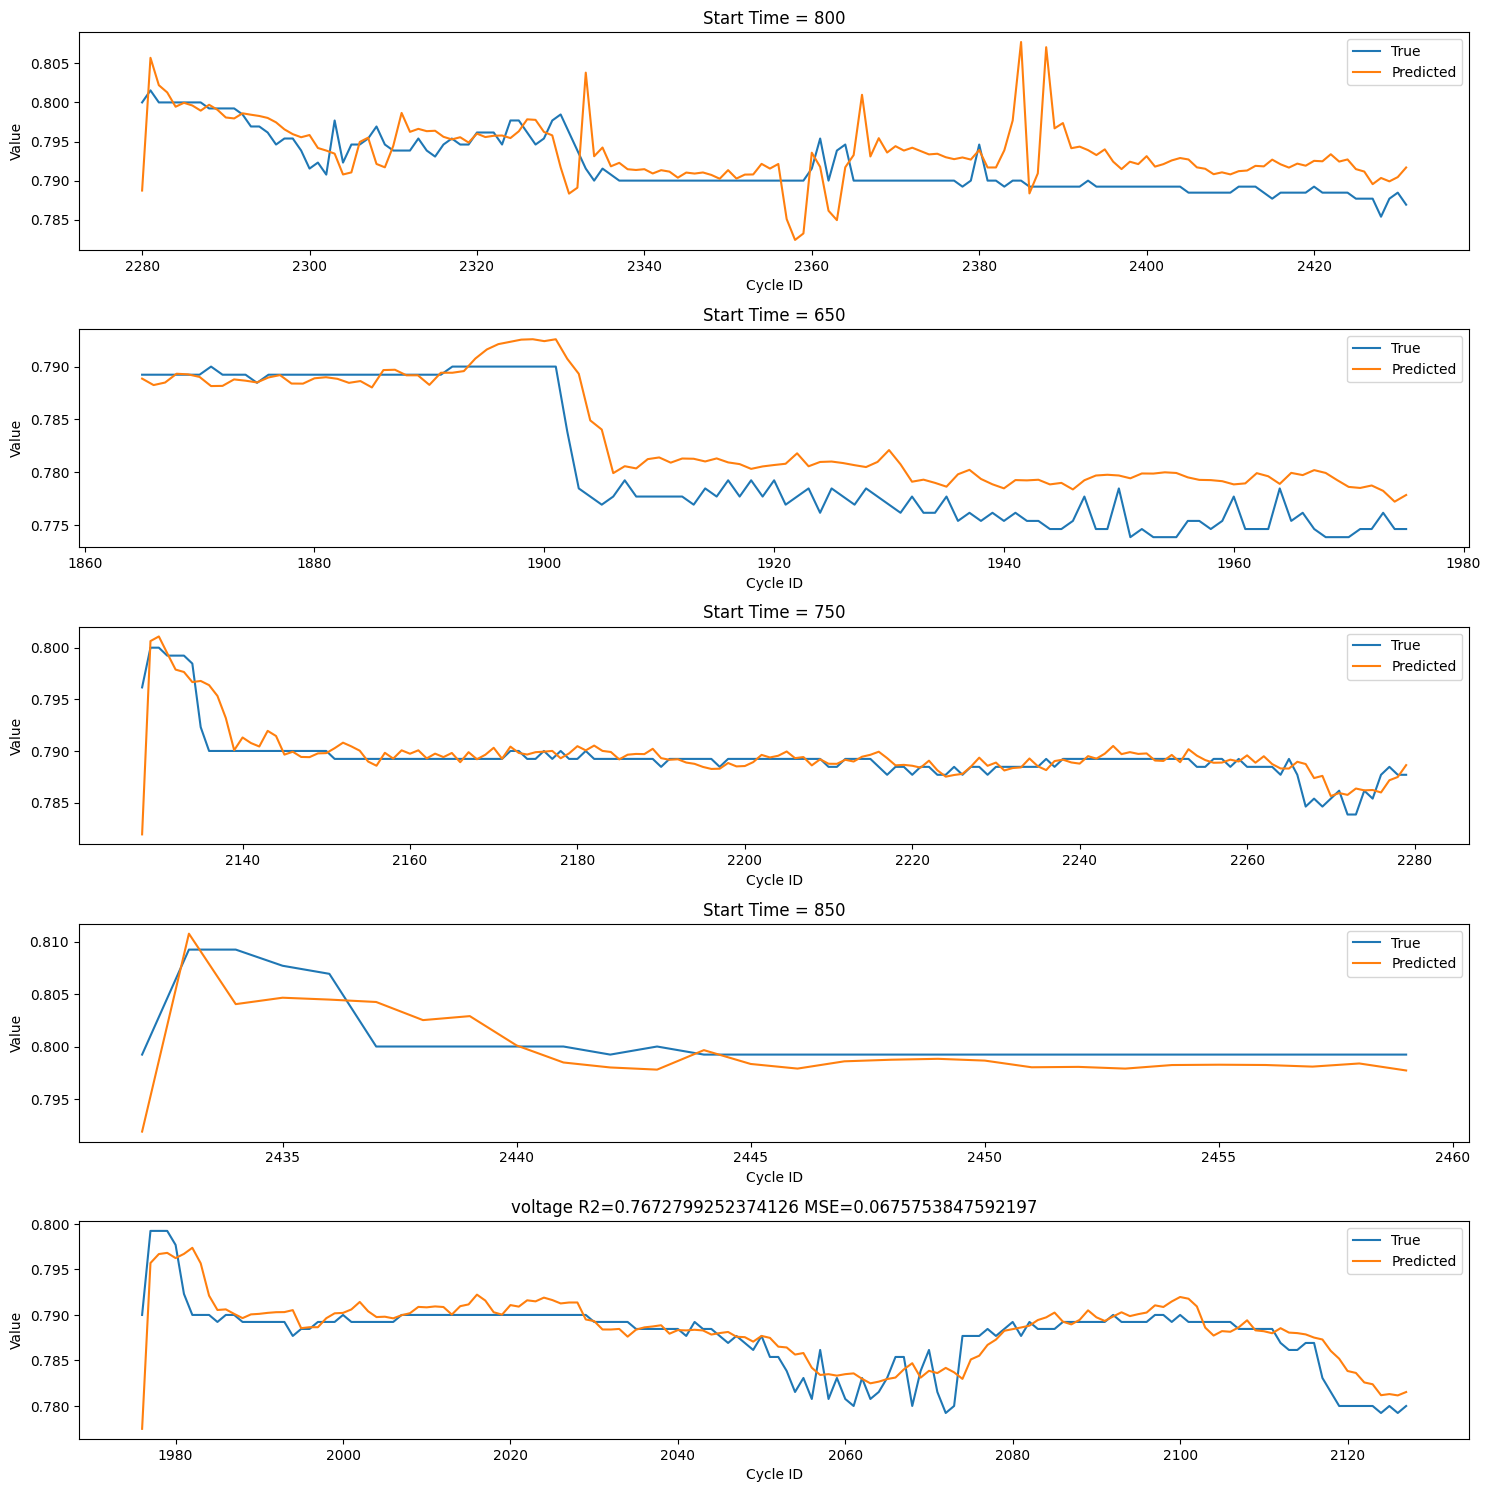

Starting evaluating voltage
Epoch 1/1 - Evaluating Loss:  0.03928383397542955 - Val Loss:  0
R2=0.7211844849029017 MSE=0.039283834878105016


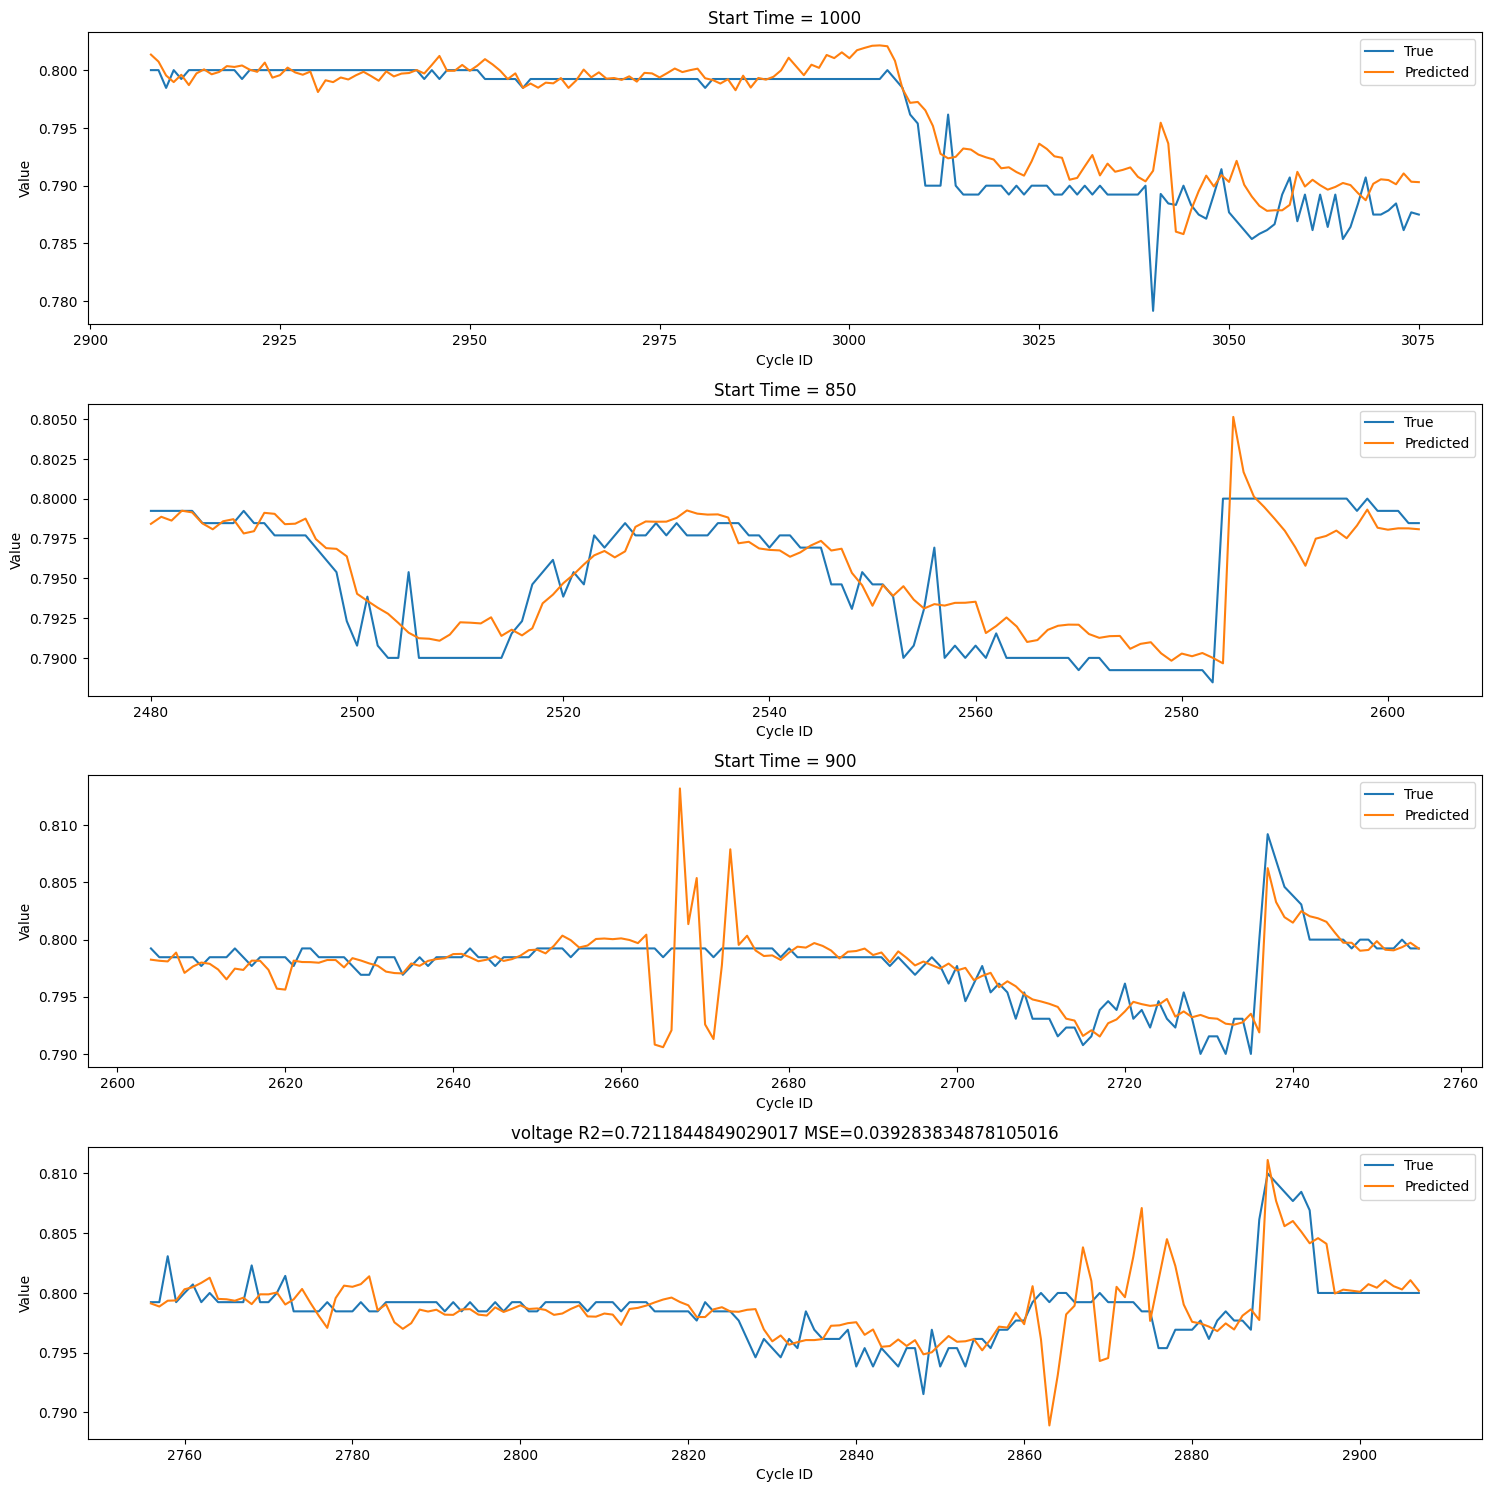

In [80]:
#@title Voltage

# instantiate the model

model = CNNMultiReservoirESN(num_features, 8,[8,16,32], output_size, 0.95)

# train and evaluate the model
train_eval_model(model, df, seq_len=20, batch_size=32, lr=0.0001, wd=0.0001,test_size=0.4,epochs=200, title="voltage")

Starting training hydrogen
Epoch 1/200 - Training Loss:  0.8828914682139996 - Val Loss:  7.781066772891689
Epoch 11/200 - Training Loss:  0.03715234604696262 - Val Loss:  6.415628551405031
Epoch 21/200 - Training Loss:  0.01886444858572414 - Val Loss:  6.288852056876303
Epoch 31/200 - Training Loss:  0.013967055087740501 - Val Loss:  6.228739913557118
Epoch 41/200 - Training Loss:  0.011588151472598587 - Val Loss:  6.167246303955233
Epoch 51/200 - Training Loss:  0.009977455737169232 - Val Loss:  6.114758435815382
Epoch 61/200 - Training Loss:  0.008786444539403984 - Val Loss:  6.073889108680698
Epoch 71/200 - Training Loss:  0.007878641641268743 - Val Loss:  6.046043708945657
Epoch 81/200 - Training Loss:  0.00713194684826233 - Val Loss:  6.027995901112487
Epoch 91/200 - Training Loss:  0.006524919335663134 - Val Loss:  6.017117556285997
Early stopping: no improvement in validation loss for 3 epochs.
Plots for last training epoch


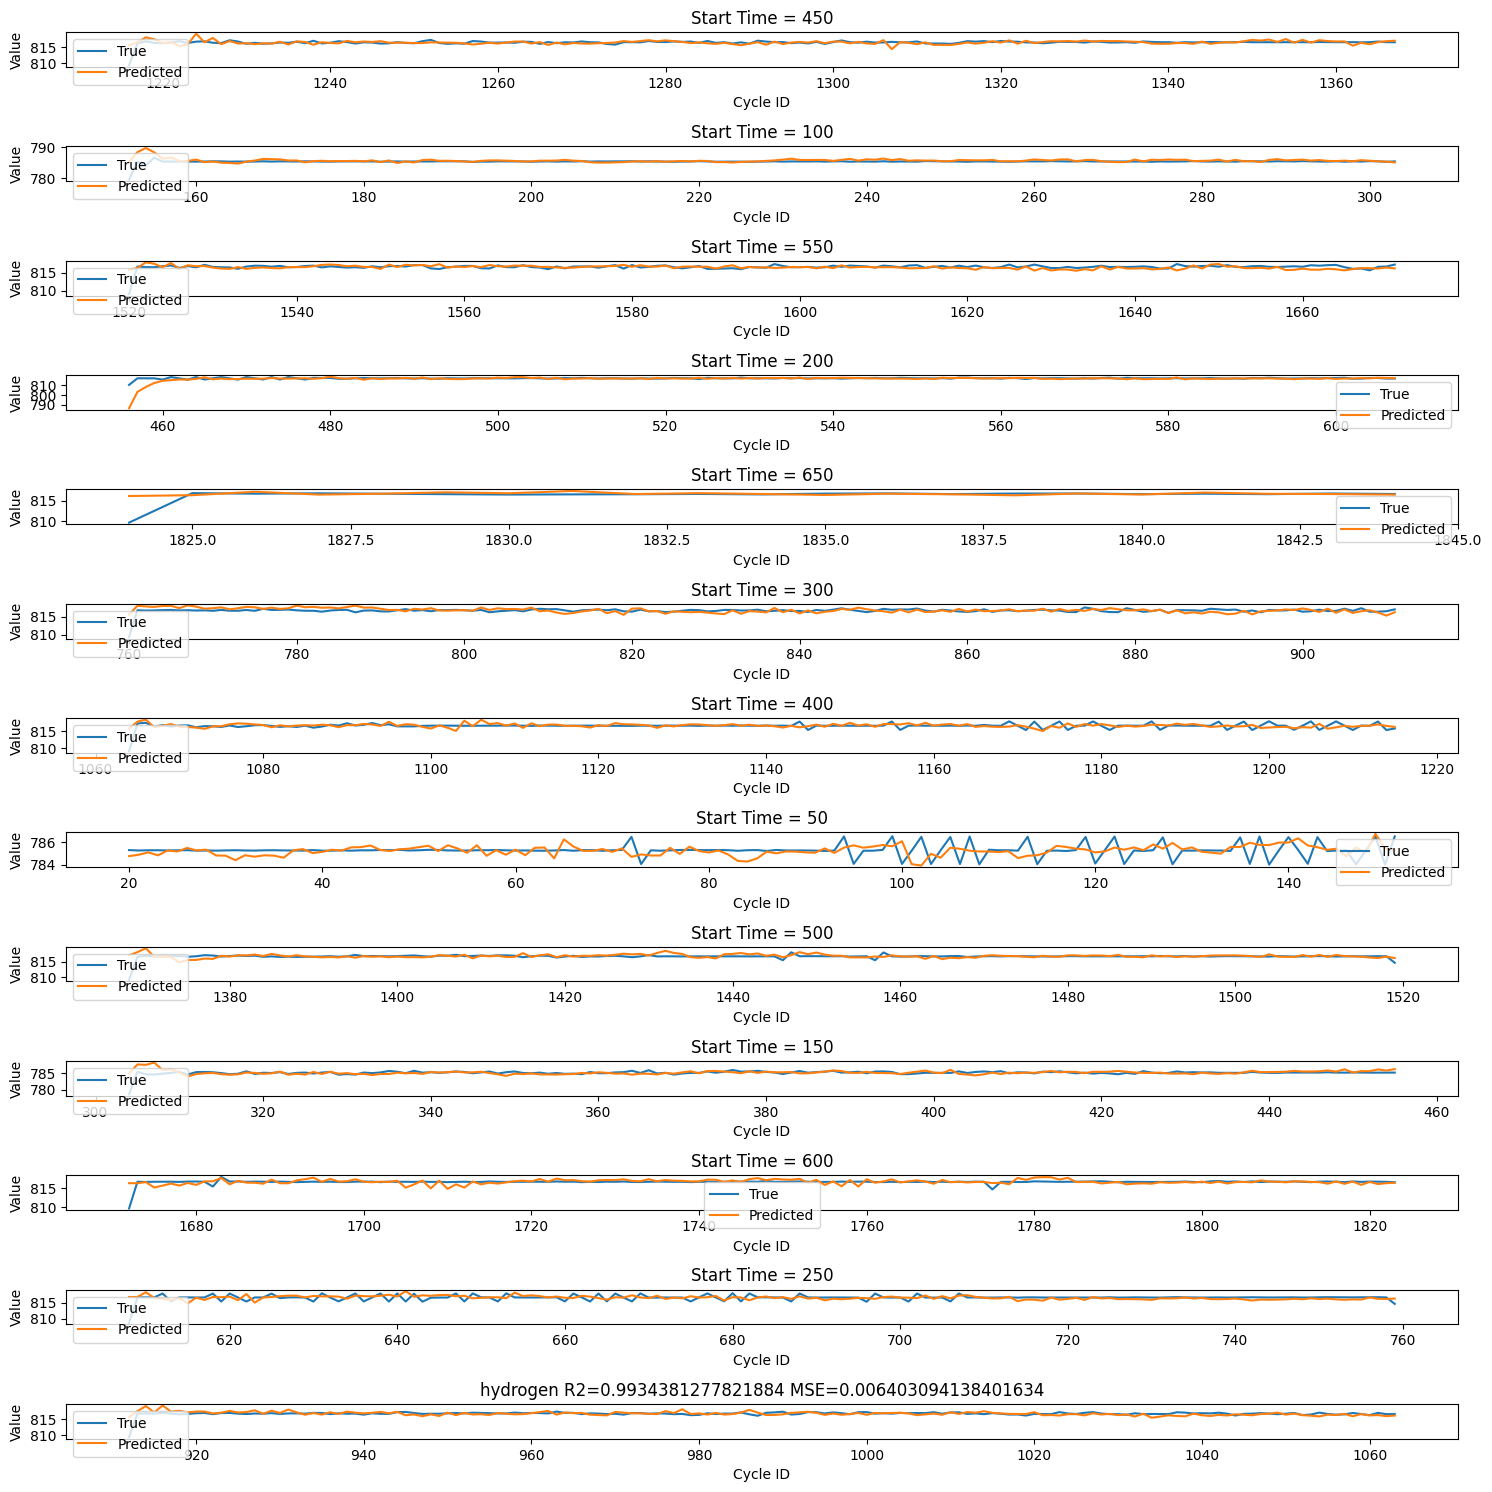

20
Plots for last evaluation
595
595


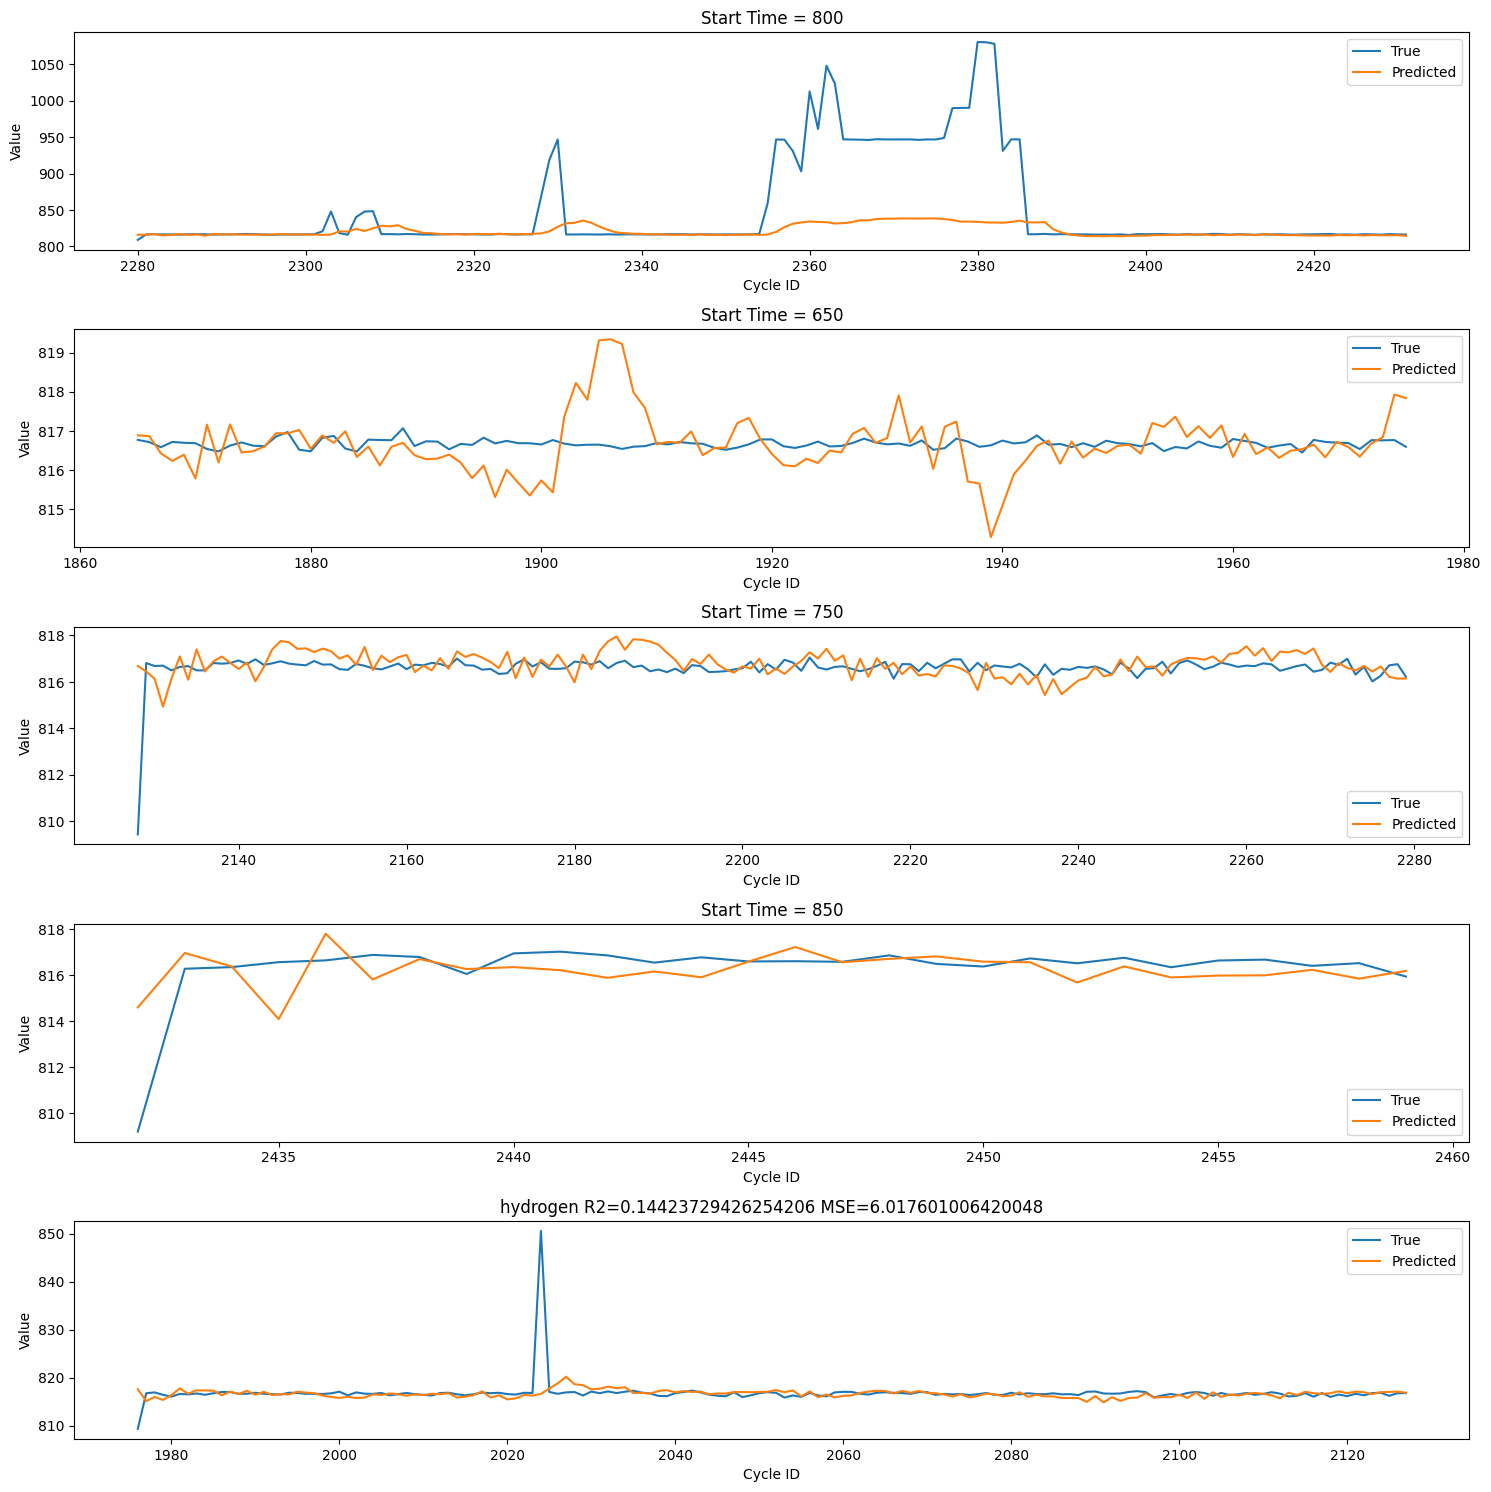

Starting evaluating hydrogen
Epoch 1/1 - Evaluating Loss:  1.8365757899294348 - Val Loss:  0
R2=0.17942889838286413 MSE=1.8365757660469473


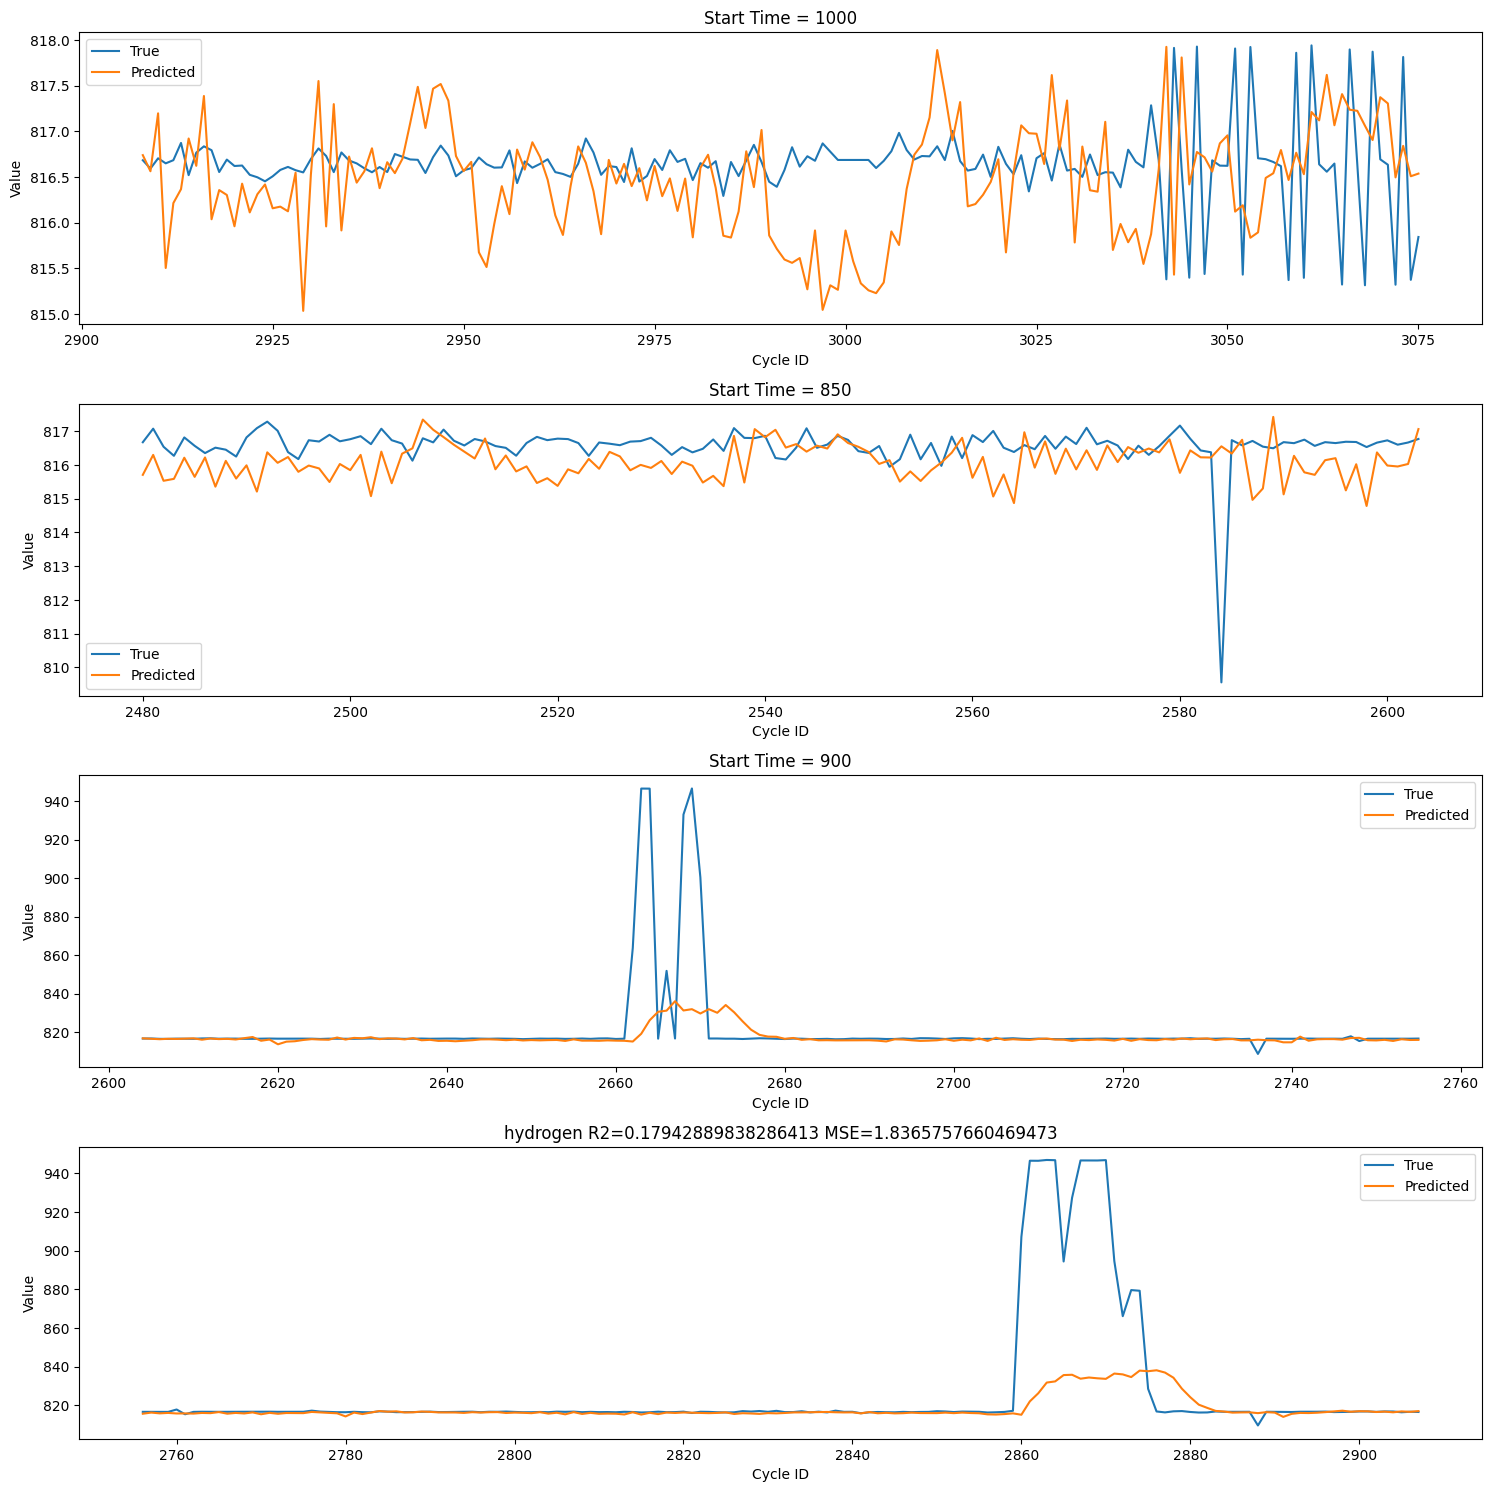

In [86]:
#@title Hydrogen


model = CNNMultiReservoirESN(num_features, 8,[8,16,32,64,128], output_size, 0.95)

# train and evaluate the model
train_eval_model(model, df, seq_len=20, batch_size=32, test_size=0.4,epochs=200, title="hydrogen")

Starting training e/h
Epoch 1/80 - Training Loss:  0.6305850127647663 - Val Loss:  1.060091385602438
Early stopping: no improvement in validation loss for 3 epochs.
Plots for last training epoch


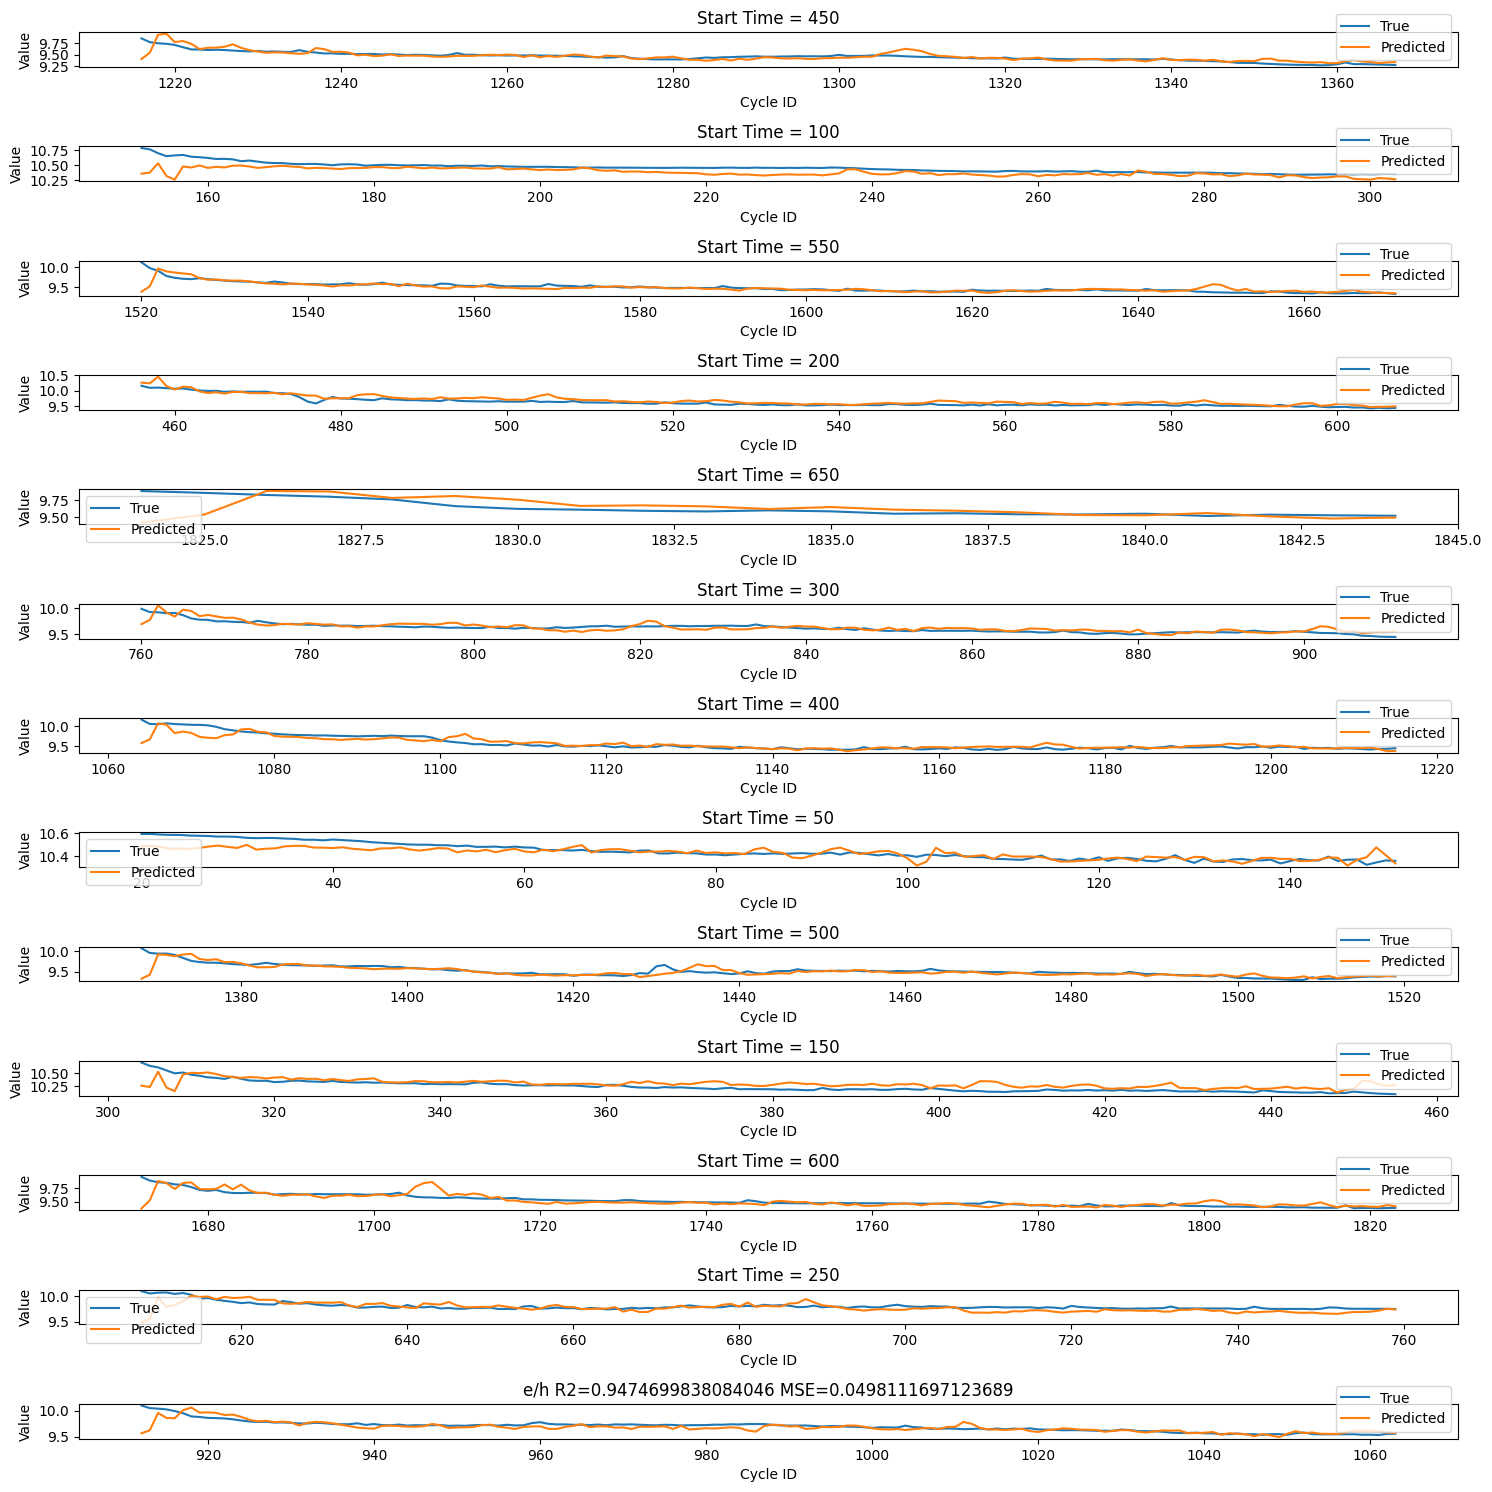

20
Plots for last evaluation
595
595


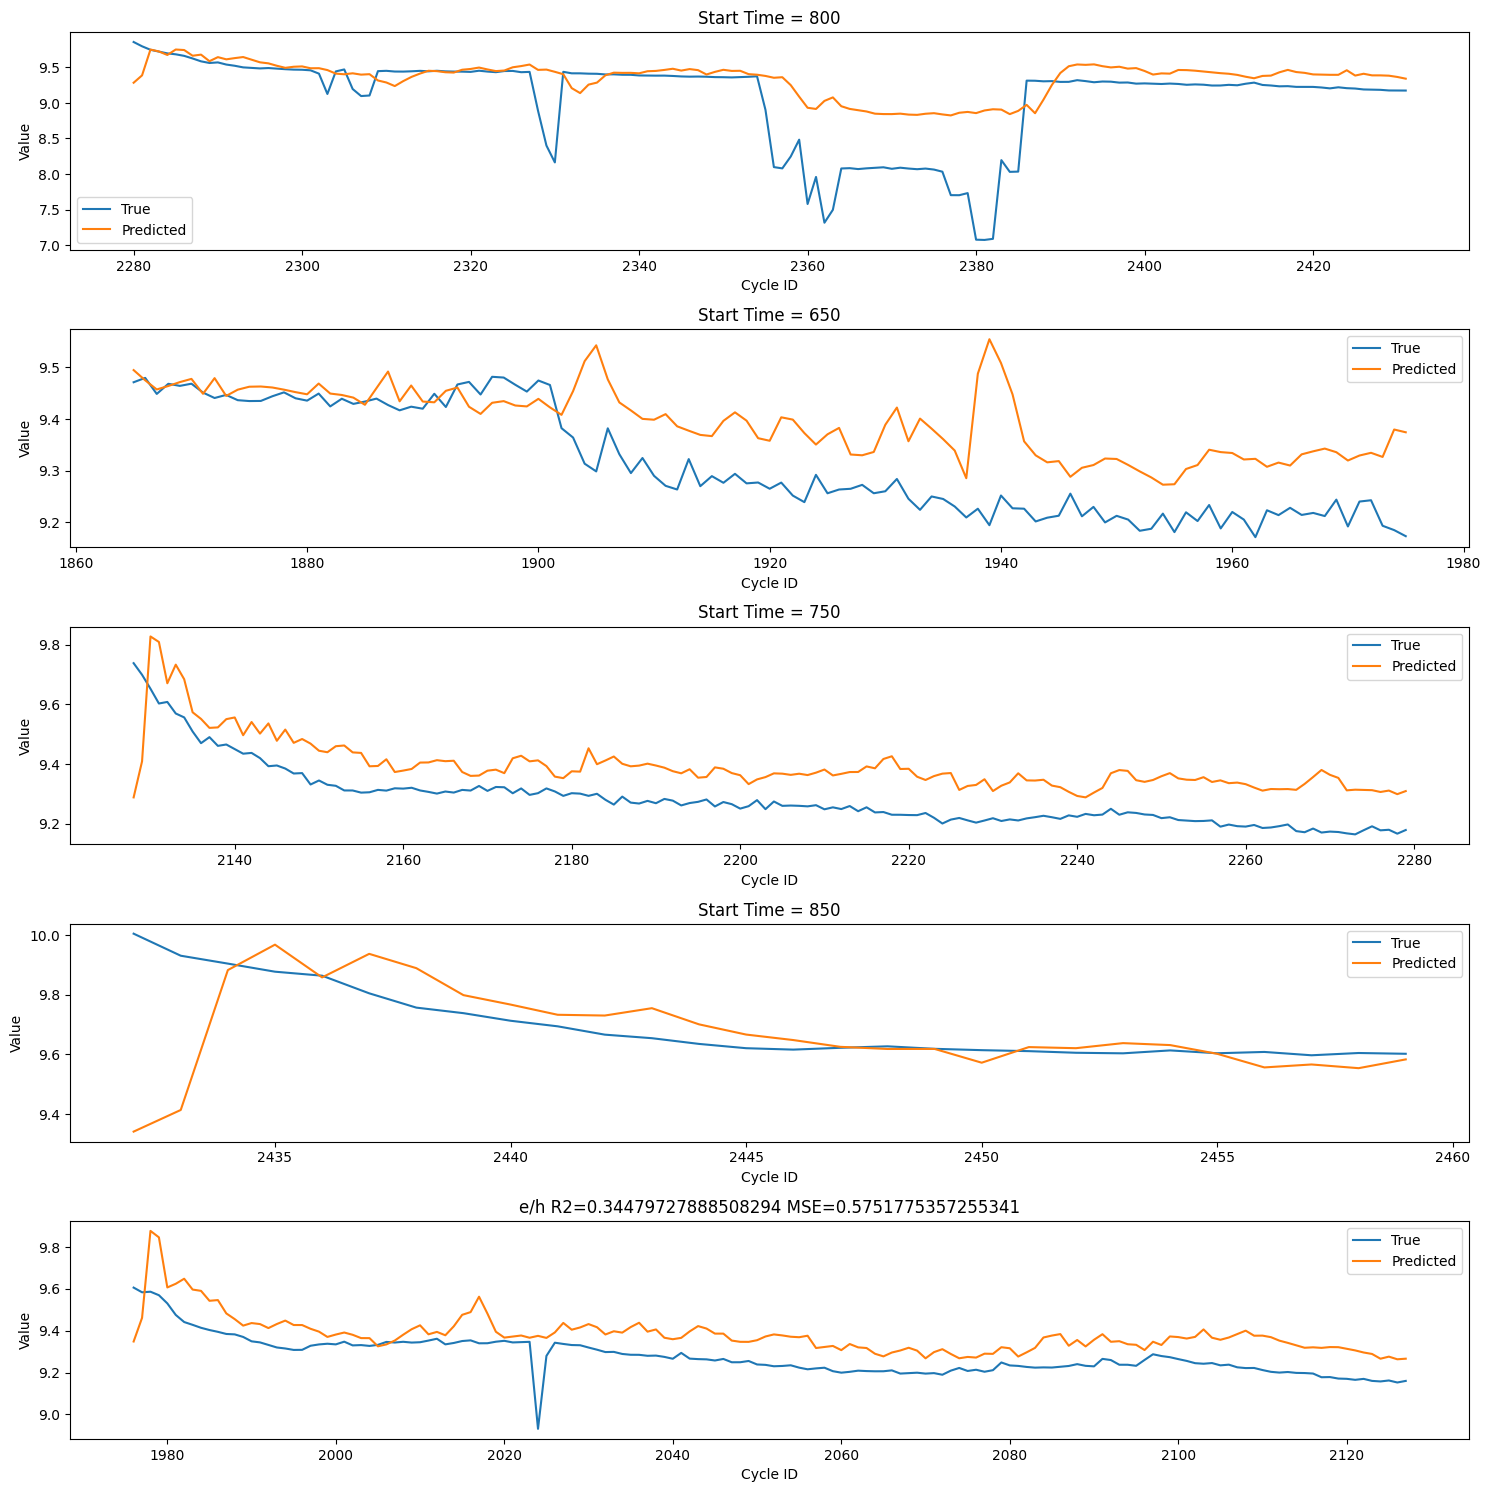

Starting evaluating e/h
Epoch 1/1 - Evaluating Loss:  0.22780801152619773 - Val Loss:  0
R2=0.4344062875728756 MSE=0.22780801074928747


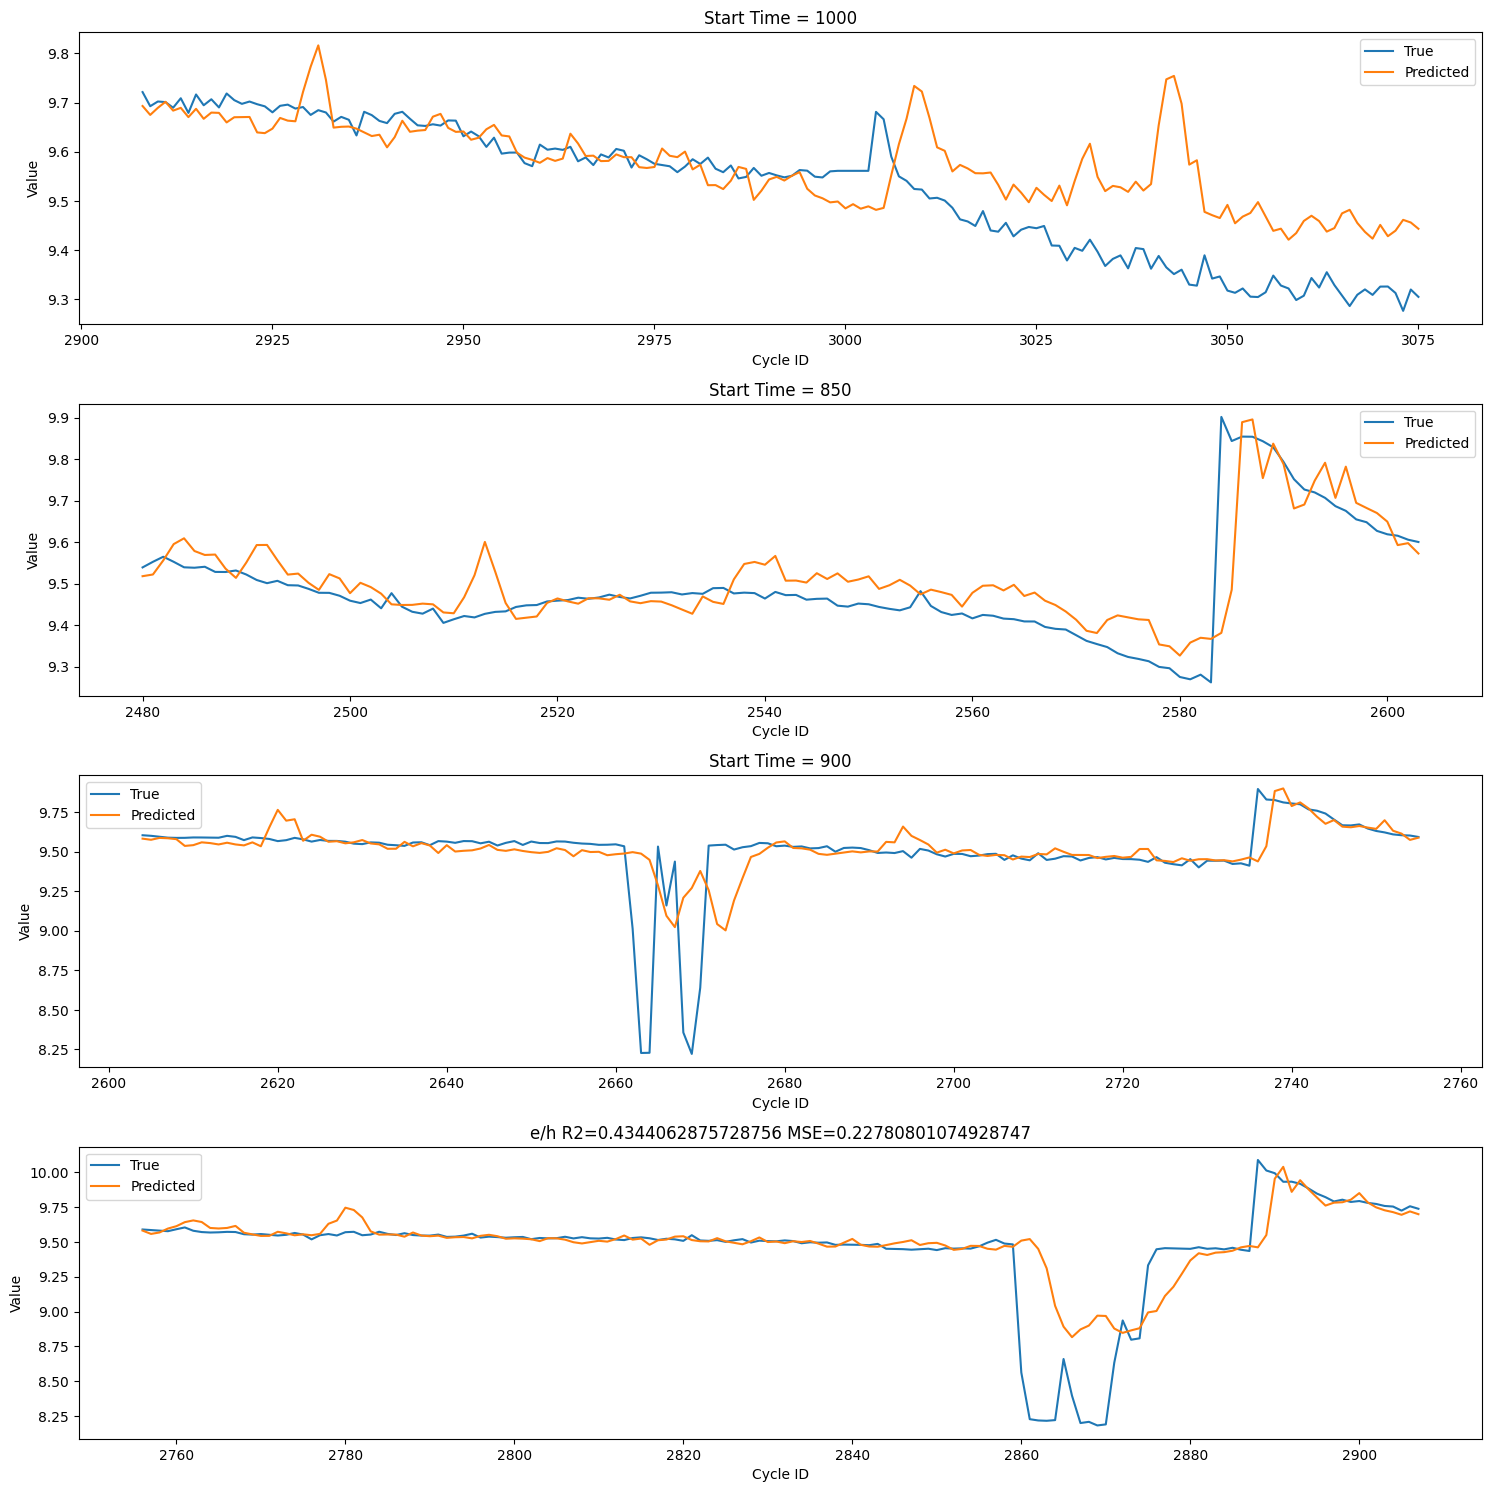

In [84]:
#@title energy/hydrogen

# instantiate the model

model = CNNMultiReservoirESN(num_features, 16,[16,32,64,128], output_size, 0.95)

# train and evaluate the model
train_eval_model(model, df, seq_len=20, batch_size=32, test_size=0.4,epochs=80, title="e/h")

Starting training p/h
Epoch 1/200 - Training Loss:  1.2406621394068773 - Val Loss:  2.6110674268252723
Epoch 11/200 - Training Loss:  0.029845068325561566 - Val Loss:  1.0380219750633108
Epoch 21/200 - Training Loss:  0.02120654242803696 - Val Loss:  0.9754477256343346
Epoch 31/200 - Training Loss:  0.01794334787650612 - Val Loss:  0.9455336646029584
Epoch 41/200 - Training Loss:  0.015907380822243106 - Val Loss:  0.9225188520286453
Epoch 51/200 - Training Loss:  0.014420688043926554 - Val Loss:  0.901298657438147
Epoch 61/200 - Training Loss:  0.013267281083871835 - Val Loss:  0.8810375472072379
Epoch 71/200 - Training Loss:  0.012289047215117848 - Val Loss:  0.8620984770070921
Epoch 81/200 - Training Loss:  0.011480262551199773 - Val Loss:  0.8447059333774153
Epoch 91/200 - Training Loss:  0.010784378225096213 - Val Loss:  0.8283245714036876
Epoch 101/200 - Training Loss:  0.010204303517419813 - Val Loss:  0.81370827499067
Epoch 111/200 - Training Loss:  0.009717848250963062 - Val Lo

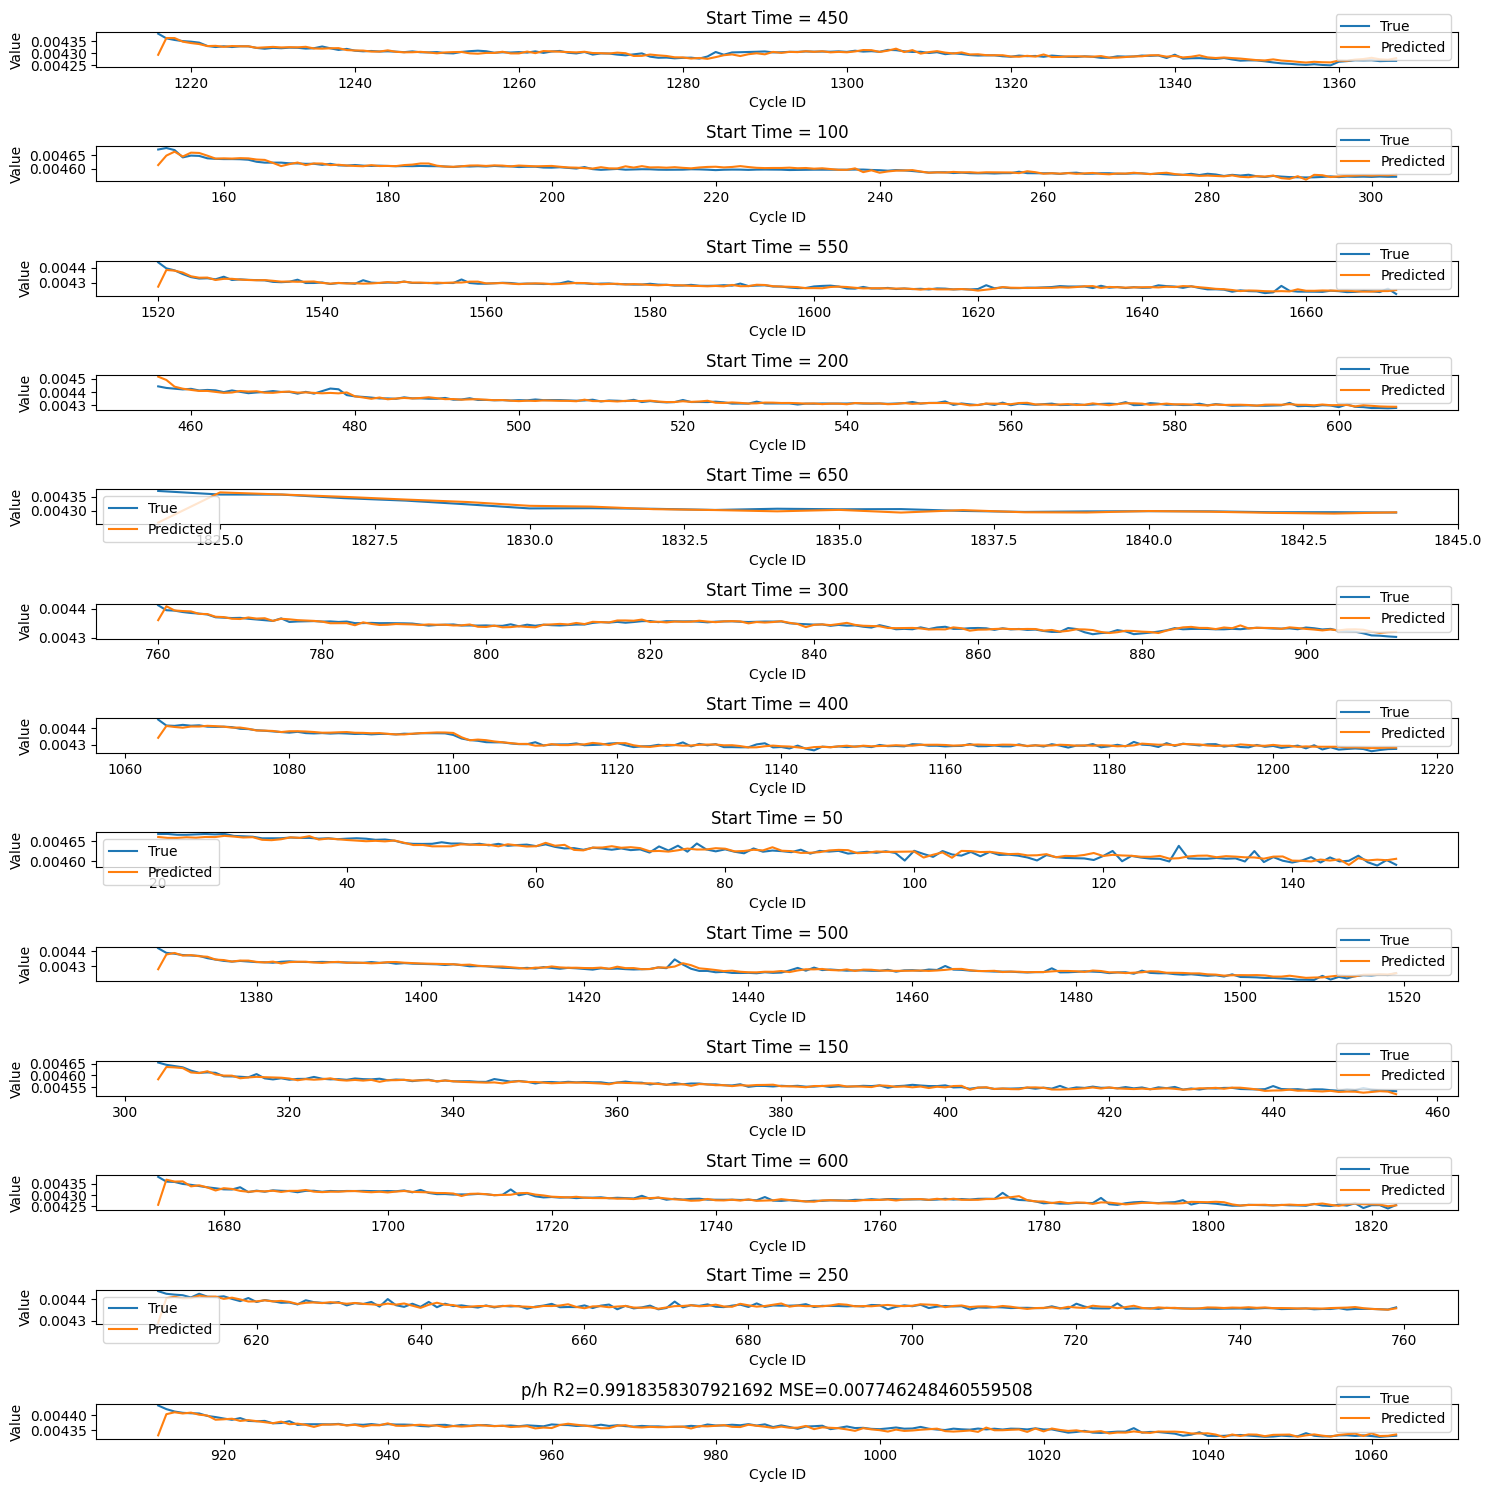

20
Plots for last evaluation
595
595


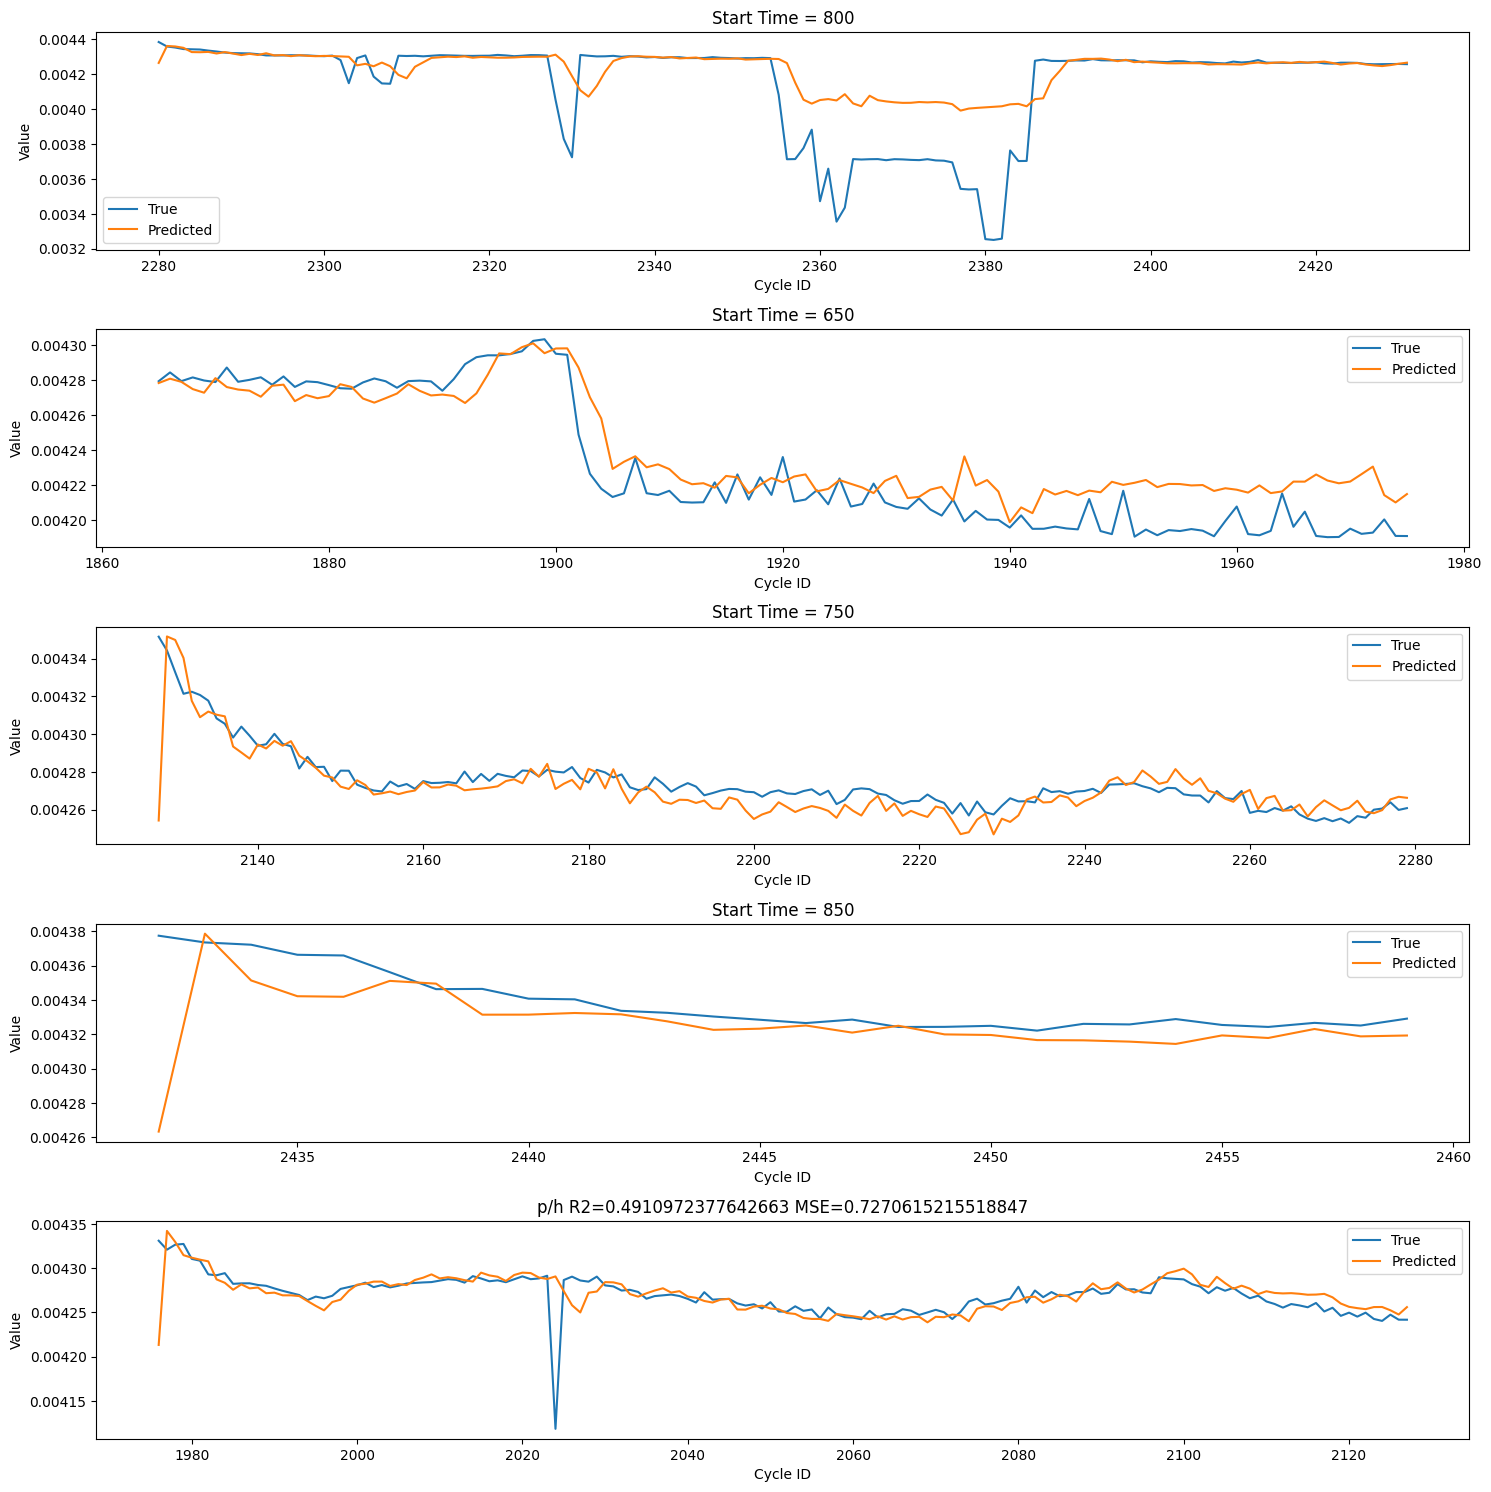

Starting evaluating p/h
Epoch 1/1 - Evaluating Loss:  0.2932431684400272 - Val Loss:  0
R2=0.4586788985581294 MSE=0.29324316995070304


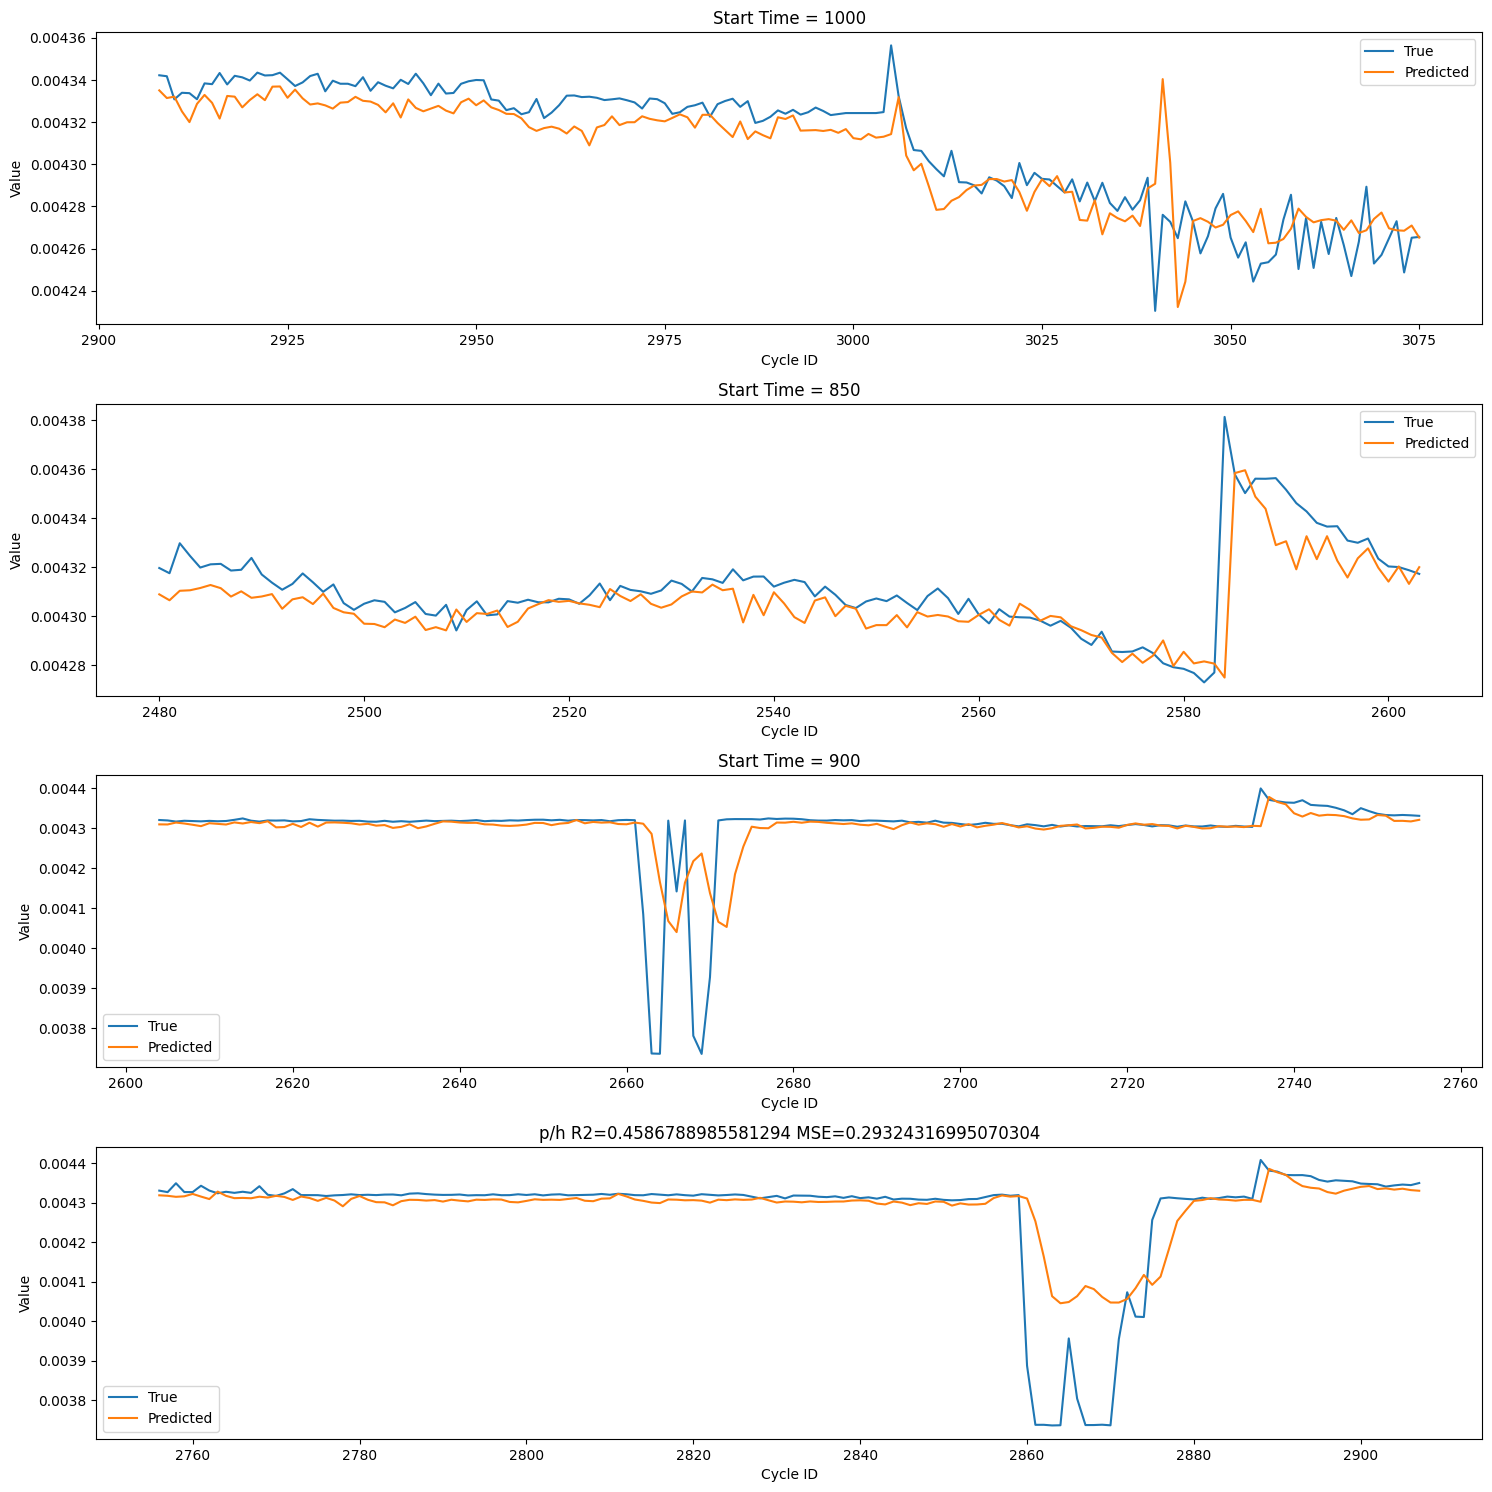

In [83]:
#@title power/hydrogen


# instantiate the model
model = CNNMultiReservoirESN(num_features, 16,[8,16,32,64], output_size, 0.95)

# train and evaluate the model
train_eval_model(model, df, seq_len=20, batch_size=32, test_size=0.4,lr=0.0001,epochs=200, title="p/h")